# Advanced Lane Finding Project

## The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)

[image1]: ./output_images/camera_calibration.jpg "Undistorted Chessfield"
[image2]: ./output_images/undistorted_test_image.jpg "Undistorted test image"

[video1]: ./project_video.mp4 "Video"


---

### Camera Calibration

The code for this step is contained in the first code cell of the IPython notebook located in "./lanefinding.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. The camera matrix and the distortion coefficients are stored in "cameraCorrection.p" with pickle.

I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]


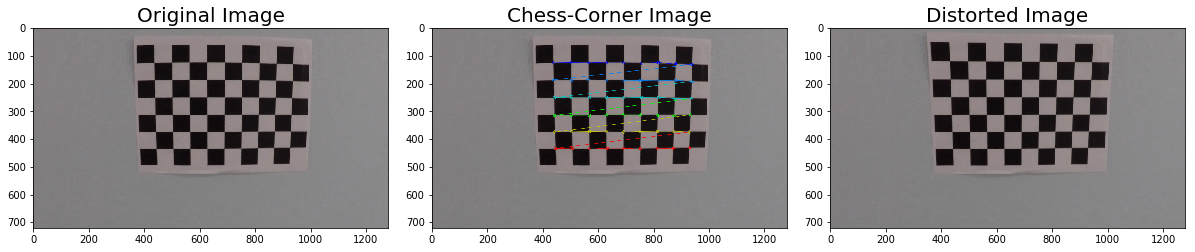

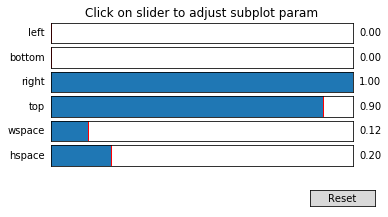

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import random

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        #cornerimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #new_name = './output_images/cc_drawCorners_' + fname.split('\\')[-1]
        #cv2.imwrite(new_name,cornerimg)

retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Save camera calibration data 
dist_pickle = {}
dist_pickle["mtx"] = cameraMatrix
dist_pickle["dist"] = distCoeffs
pickle.dump( dist_pickle, open( "./cameraCorrection.p", "wb" ) )


# Plot and save the process of undistortion of random image
randIndex = random.randint(0,len(images))
original = cv2.imread(images[randIndex])
imgtemp = cv2.imread(images[randIndex])
gray = cv2.cvtColor(imgtemp,cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
# Draw and display the corners
drawChessImg = cv2.drawChessboardCorners(imgtemp, (9,6), corners, ret)
cv2.imwrite('./output_images/chess_drawCorners.jpg', drawChessImg)
distimg = cv2.undistort(original, cameraMatrix, distCoeffs, None, cameraMatrix)
cv2.imwrite('./output_images/chess_undistored.jpg', distimg)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 96))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(drawChessImg)
ax2.set_title('Chess-Corner Image', fontsize=20)
ax3.imshow(distimg)
ax3.set_title('Distorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.subplot_tool()
plt.show()

---
[//]: # (Image References)
[image2]: ./output_images/undistorted_test_image.jpg "Undistorted test image"
[image3]: ./output_images/test_image_binarys.png "different binary transformations"

### Pipeline (single images) 

#### Image distortion-correction
By using the stored camera correction coefficients, the images will be undistorted.

![alt text][image2]

#### Create thresholded binary image

There are different methods to extract the edges, which are potentially lane lines, and display them in a binary image. Different lane line colors, shapes and lengths need to be recognizeds. The images also can include shaddows or reflections and so on. Therefore I create more than one binary image and combine them in the end.
- Using the sobel filter with a gradient threshold of 20 to 100 in x orientation
- Using the sobel filter with a gradient threshold of 20 to 100 in y orientation
- Creating a magnitued binary which represents the absolut values of the sobel filter output (magnitude of gradient) in x and y direction
- Additional I'm using a direction filtered binary image, which only displays the direction of the magnitued which has a slope of 0.7 to 1.3
- Using the S-Channel in a HLS color space converted image helps me to extract colored (yellow) lines

All these binary images are combined to one resulting image.

```python
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
```

![alt text][image3]


#### Perform a perspective transform

Next step in the image pipeline is the perspective transform from front view to bird view. This is done by defining a isosceles trapezoid in the image area where a straight road is expected to be found. Transforming this image into a rectangle gives me a birdview of the road. Only in the birdview, the lane lines are printed parallel to each other. In this perspective I will be able to calculate the radius of a curve.


I also tried first to do the perspective transform, and afterwards creating the thresholded binarys on the transformed images. The extracted lines look smarter, but also cliched, which is not a improvement, when calculating a polynom for the lane line.


#### Identify lane-line pixels

#### Calculate the radius of curvatur and car position

#### Plot the identified lane



In [1]:
import cv2
import numpy as np
import pickle

#load camera matrix and dist coefficients
calib_dist = pickle.load(open("./cameraCorrection.p","rb"))
mtx = calib_dist["mtx"]
dist = calib_dist["dist"]

# Image distortion-correction
def undistort_image(img, cameraMatrix, distCoeffs):
    return cv2.undistort(img, cameraMatrix,distCoeffs, None, cameraMatrix)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your dir_binary image
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_binary = np.zeros_like(hls[:, :, 2])
    hls_binary[(hls[:, :, 2] > thresh[0]) & (hls[:, :, 2]<= thresh[1])] = 1
    return hls_binary

# Define a function that thresholds the S-channel of HSV
# Use exclusive lower bound (>) and inclusive upper (<=)
def hsv_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the S channel
    hsv_binary = np.zeros_like(hsv[:, :, 1])
    hsv_binary[(hsv[:, :, 1] > thresh[0]) & (hsv[:, :, 1]<= thresh[1])] = 1
    return hsv_binary

# Define a function that thresholds the L-channel of LUV
# Use exclusive lower bound (>) and inclusive upper (<=)
def luv_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # 2) Apply a threshold to the S channel
    luv_binary = np.zeros_like(luv[:, :, 0])
    luv_binary[(luv[:, :, 0] > thresh[0]) & (luv[:, :, 0]<= thresh[1])] = 1
    return luv_binary

# Define a function that thresholds the V-channel of LUV
# Use exclusive lower bound (>) and inclusive upper (<=)
def luv_selectV(img, thresh=(0, 255)):
    # 1) Convert to LUV color space
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # 2) Apply a threshold to the S channel
    luv_binary = np.zeros_like(luv[:, :, 2])
    luv_binary[(luv[:, :, 2] > thresh[0]) & (luv[:, :, 2]<= thresh[1])] = 1
    return luv_binary

# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=)
def lab_select(img, thresh=(0, 255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # 2) Apply a threshold to the S channel
    lab_binary = np.zeros_like(lab[:, :, 2])
    lab_binary[(lab[:, :, 2] > thresh[0]) & (lab[:, :, 2]<= thresh[1])] = 1
    return lab_binary



# Transform image with 
# src: 4 coordinates which describe the trapezoid
# dst: 4 coordinates which describe a rectangle
def perspective_transformation(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

#img[in] must be a binary wrapped image
#nwindows[in] is the number of windows to be used to slide in y direction
#minpix[in] is the minimum number of pixels found to recenter window
#margin[in] Set the width of the windows +/- margin 
def sliding_window_line_extraction(img, nwindows = 9, minpix = 50, \
                                   margin = 100, left_fit= [0,0,0], \
                                   right_fit = [0,0,0]):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    if (left_fit[2] <= 0) | (right_fit[2] <= 0):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[np.int(img.shape[0]/2):,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
    
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
    
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    return left_lane_inds, right_lane_inds

def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_points = np.array(np.linspace(0, 719, 720))
    y_eval = np.max(y_points)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def pipeline_image(image):
    
    #global gLeftFit
    #global gRightFit
    global left_fitx
    global right_fitx
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistimg = undistort_image(image, mtx, dist)
    imshape = undistimg.shape
    y_siz = imshape[0]
    x_siz = imshape[1]
    vertices_source = np.float32([[(x_siz / 2) - 55, y_siz / 2 + 100],
                                [((x_siz / 6) - 10), y_siz - 25],
                                [(x_siz * 5 / 6) + 60, y_siz - 25],
                                [(x_siz / 2 + 55), y_siz / 2 + 100]])
    vertices_dest = np.float32([[(x_siz*0.25), 0],
                                [(x_siz*0.25), y_siz],
                                [(x_siz*0.75), y_siz],
                                [(x_siz*0.75), 0]])
    birdview_undist = perspective_transformation(undistimg, vertices_source, vertices_dest)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(birdview_undist, orient='x', sobel_kernel=3, thresh=(32,95))
    mag_binary = mag_thresh(undistimg, sobel_kernel=3, mag_thresh=(35,130))
    mag_binary_bv = perspective_transformation(mag_binary, vertices_source, vertices_dest)
    dir_binary = dir_threshold(undistimg, sobel_kernel=3, thresh=(0.7, 1.3))
    dir_binary_bv = perspective_transformation(dir_binary, vertices_source, vertices_dest)
    sHls_binary = hls_select(birdview_undist, thresh=(190, 220))
    lLuv_binary = luv_select(birdview_undist, thresh=(200, 255))
    bLab_binary = lab_select(birdview_undist, thresh=(142,200))
    combined = np.zeros_like(mag_binary)
    combined[(((sHls_binary == 1) | (lLuv_binary == 1)) \
                & ((dir_binary_bv == 1) | (mag_binary_bv == 1) | (gradx == 1))) | (bLab_binary == 1)] = 1
    
    
    if (Left.detected == False) or (Right.detected == False):
        left_lane_inds, right_lane_inds = sliding_window_line_extraction(combined, 9, 50, \
                                   100, [0,0,0], [0,0,0])
    else:
        left_lane_inds, right_lane_inds = sliding_window_line_extraction(combined, 9, 50, \
                                   100, Left.best_fit, Right.best_fit)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # make prediction here, define a bad line if needed
    
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    
    if(len(leftx) == 0):
        Left.detected = False
        #gLeftFit = None
    else:
        Left.updateCurrent(leftx,lefty)
        #left_fit = np.polyfit(lefty, leftx, 2)
        #gLeftFit = np.polyfit(lefty, leftx, 2)
        #left_fitx = gLeftFit[0]*ploty**2 + gLeftFit[1]*ploty + gLeftFit[2]
        #left_fitx = gLeftFit[0]*ploty**2 + gLeftFit[1]*ploty + gLeftFit[2]

    if(len(rightx) == 0):
        Right.detected = False
        #gRightFit = None
    else:
        Right.updateCurrent(rightx,righty)
        # Fit a second order polynomial to each
        #right_fit = np.polyfit(righty, rightx, 2)
        #gRightFit = np.polyfit(righty, rightx, 2)
        #right_fitx = gRightFit[0]*ploty**2 + gRightFit[1]*ploty + gRightFit[2]
    
    left_fitx = Left.current_fit[0]*ploty**2 + Left.current_fit[1]*ploty + Left.current_fit[2]
    right_fitx = Right.current_fit[0]*ploty**2 + Right.current_fit[1]*ploty + Right.current_fit[2]
    #Validate:
    # Change to best fit
    valid = True
    # distance of coefficents of two lines
    distance_coeffs_0 = np.abs(Left.current_fit[0] - Right.current_fit[0])
    distance_coeffs_1 = np.abs(Left.current_fit[1] - Right.current_fit[1])
    if((distance_coeffs_0 >= 0.004) | (distance_coeffs_1 >= 0.8)):
        valid = False
        print("distance_coeffs_0: ", distance_coeffs_0)
        print("distance_coeffs_1: ", distance_coeffs_1)
    

    # distance of coefficents from current lane to bestfit lane
    distance_coeffs_right_0 = np.abs(Right.current_fit[0] - Right.best_fit[0])
    distance_coeffs_right_1 = np.abs(Right.current_fit[1] - Right.best_fit[1])
    distance_coeffs_right_2 = np.abs(Right.current_fit[2] - Right.best_fit[2])
    distance_coeffs_left_0 = np.abs(Left.current_fit[0] - Left.best_fit[0])
    distance_coeffs_left_1 = np.abs(Left.current_fit[1] - Left.best_fit[1])
    distance_coeffs_left_2 = np.abs(Left.current_fit[2] - Left.best_fit[2])
    
    if((distance_coeffs_right_0 >= 0.001) | (distance_coeffs_left_0 >= 0.001)):
        valid = False
        print("distance_coeffs_right_0: ", distance_coeffs_right_0)
        print("distance_coeffs_left_0: ", distance_coeffs_left_0)
    
    if((distance_coeffs_right_1 >= 1.00) | (distance_coeffs_left_1 >= 1.00)):
        valid = False
        print("distance_coeffs_right_1: ", distance_coeffs_right_1)
        print("distance_coeffs_left_1: ", distance_coeffs_left_1)
    
    #if((distance_coeffs_right_2 >= 100.0) | (distance_coeffs_left_2 >= 100.0)):
    #    valid = False
    #    print("distance_coeffs_right_2: ", distance_coeffs_right_2)
    #    print("distance_coeffs_left_2: ", distance_coeffs_left_2)

    
    # distance of the two lines
    distance_pixel = np.abs(left_fitx[-1] - right_fitx[-1])
    distance_meters  = xm_per_pix*distance_pixel
    if((distance_meters <= 2.5) | (distance_meters >= 3.4)):
        valid = False
        print("distance_meters: ", distance_meters)
    
    
    
    if(valid == True):
        Left.applyCurrent()
        Right.applyCurrent()
    
    left_fitx = Left.best_fit[0]*ploty**2 + Left.best_fit[1]*ploty + Left.best_fit[2]
    right_fitx = Right.best_fit[0]*ploty**2 + Right.best_fit[1]*ploty + Right.best_fit[2]
    #left_fitx = Left.current_fit[0]*ploty**2 + Left.current_fit[1]*ploty + Left.current_fit[2]
    #right_fitx = Right.current_fit[0]*ploty**2 + Right.current_fit[1]*ploty + Right.current_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transformation(color_warp, vertices_dest, vertices_source)

    left_curve_rad = measure_radius_of_curvature(left_fitx)
    right_curve_rad = measure_radius_of_curvature(right_fitx)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_fitx[-1] + left_fitx[-1])/2
    
    center_offset_pixels = abs(undistimg.shape[1]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistimg, 1, newwarp, 0.3, 0)
    cv2.putText(result, curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return result

    # Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n_fits = 10):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # number of values for each of the n fits
        self.n_values_per_fit = []
        # number of fits to store
        self.n_fits = n_fits
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        #x values for detected line pixels
        self.current_allx = None  
        #y values for detected line pixels
        self.current_ally = None
        
        
    def updateCurrent(self, x, y):
        """
        Updates the line representation.
        :param x: list of x values
        :param y: list of y values
        """
        assert len(x) == len(y), 'x and y have to be the same size'

        self.current_allx = x
        self.current_ally = y

        self.current_fit = np.polyfit(self.current_ally, self.current_allx, 2)

        self.detected = False
        
        if self.best_fit is None:
            self.applyCurrent()
        

        
    def applyCurrent(self):
        self.n_values_per_fit.append(len(self.current_allx))
        self.recent_xfitted.extend(self.current_allx)
        
        if len(self.n_values_per_fit) > self.n_fits:
            n_x_to_remove = self.n_values_per_fit.pop(0)
            self.recent_xfitted = self.recent_xfitted[n_x_to_remove:]
        self.bestx = np.mean(self.recent_xfitted)

        if self.best_fit is None:
            self.best_fit = self.current_fit
        else:
            self.best_fit = (self.best_fit * (self.n_fits - 1) + self.current_fit) / self.n_fits
        self.detected = True


In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random



# Make a list of calibration images 
images = glob.glob('frames_video/*.jpg')
#images = glob.glob('test_images/*.jpg')
#randIndex = random.randint(0,len(images)-1)
#img = cv2.imread(images[randIndex])
for image in images:
    img = cv2.imread(image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistimg = undistort_image(img_rgb, mtx, dist)
    
    #defining source points for transforming image
    imshape = undistimg.shape
    y_siz = imshape[0]
    x_siz = imshape[1]
    vertices_source = np.float32([[(x_siz / 2) - 55, y_siz / 2 + 100],
        [((x_siz / 6) - 10), y_siz - 25],
        [(x_siz * 5 / 6) + 60, y_siz - 25],
        [(x_siz / 2 + 55), y_siz / 2 + 100]])
    
    vertices_dest = np.float32([[(x_siz*0.25), 0],
                                [(x_siz*0.25), y_siz],
                                [(x_siz*0.75), y_siz],
                                [(x_siz*0.75), 0]])
    
    birdview_undist = perspective_transformation(undistimg, vertices_source, vertices_dest)
    #birdview_combined = perspective_transformation(combined, vertices_source, vertices_dest)

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(birdview_undist, orient='x', sobel_kernel=ksize, thresh=(32,95))
    grady = abs_sobel_thresh(birdview_undist, orient='y', sobel_kernel=ksize, thresh=(20,100))
    mag_binary = mag_thresh(undistimg, sobel_kernel=ksize, mag_thresh=(35,130))
    mag_binary_bv = perspective_transformation(mag_binary, vertices_source, vertices_dest)
    dir_binary = dir_threshold(undistimg, sobel_kernel=ksize, thresh=(0.7, 1.3))
    dir_binary_bv = perspective_transformation(dir_binary, vertices_source, vertices_dest)
    sHls_binary = hls_select(birdview_undist, thresh=(190, 220))
    lLuv_binary = luv_select(birdview_undist, thresh=(200, 255))
    vLuv_binary = luv_selectV(birdview_undist, thresh=(115,255))
    bLab_binary = lab_select(birdview_undist, thresh=(145,200))
    combined = np.zeros_like(mag_binary)
    #combined[(gradx == 1) | ((mag_binary_bv == 1) & (dir_binary_bv == 1))\
    #         | (((sHls_binary == 1) | (lLuv_binary == 1)) \
    #            & (dir_binary_bv == 1)) | (bLab_binary == 1)] = 1
    combined[(((sHls_binary == 1) | (lLuv_binary == 1)) \
                & ((dir_binary_bv == 1) | (mag_binary_bv == 1) | (gradx == 1))) | (bLab_binary == 1)] = 1
    
    # Plot and save undistorted test image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 64))
    f.tight_layout()
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(undistimg)
    ax2.set_title('Undistorted Image', fontsize=20)
    xs, ys = zip(*vertices_source) #create lists of x and y values
    ax2.plot(xs,ys, 'r')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.subplot_tool()
    plt.show()
    plt.gcf().clear()
    
    
    # Plot color and gradient transformation
    
    f, ((ax1, ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5, 2, figsize=(10, 16))
    f.tight_layout()
    ax1.imshow(dir_binary_bv, cmap='gray')
    ax1.set_title('Direction Binary', fontsize=20)
    ax2.imshow(gradx, cmap='gray')
    ax2.set_title('Sobel Grad X', fontsize=20)
    ax3.imshow(grady, cmap='gray')
    ax3.set_title('Sobel Grad Y', fontsize=20)
    ax4.imshow(mag_binary_bv, cmap='gray')
    ax4.set_title('Magnitude Binary', fontsize=20)
    ax5.imshow(sHls_binary, cmap='gray')
    ax5.set_title('S of HLS Binary', fontsize=20)
    ax6.imshow(birdview_undist, cmap='gray')
    ax6.set_title('Birdview undistorted', fontsize=20)
    ax7.imshow(lLuv_binary, cmap='gray')
    ax7.set_title('L of LUV Binary', fontsize=20)
    ax8.imshow(bLab_binary, cmap='gray')
    ax8.set_title('B of LAB Binary', fontsize=20)
    ax9.imshow(vLuv_binary, cmap='gray')
    ax9.set_title('V of LUV Binary', fontsize=20)
    ax10.imshow(combined, cmap='gray')
    ax10.set_title('Combined Binary', fontsize=20)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.subplot_tool()
    plt.show()
    plt.gcf().clear()
    
    
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

test_wrap1 = combined
test_wrap2 = combined
# Get polynoms
left_lane_inds, right_lane_inds = sliding_window_line_extraction(test_wrap1)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((test_wrap2, test_wrap2, test_wrap2))*255

# Identify the x and y positions of all nonzero pixels in the image
nonzero = test_wrap2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, test_wrap1.shape[0]-1, test_wrap1.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

print(nonzeroy[left_lane_inds])
print(nonzerox[left_lane_inds])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

# Create an image to draw the lines on
warp_zero = np.zeros_like(combined).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = perspective_transformation(color_warp, vertices_dest, vertices_source)

# Combine the result with the original image
result = cv2.addWeighted(undistimg, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.subplot_tool()
plt.show()




[640 640 640 ..., 159 159 159]
[368 369 370 ..., 484 485 486]


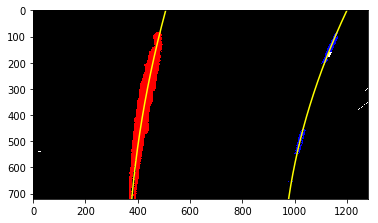

[ 81  82  83 ..., 719 719 719]
[471 471 470 ..., 390 391 392]


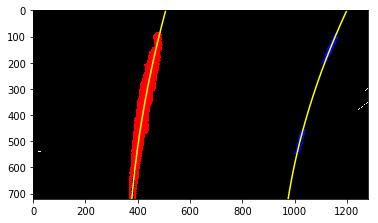

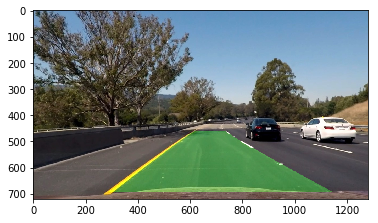

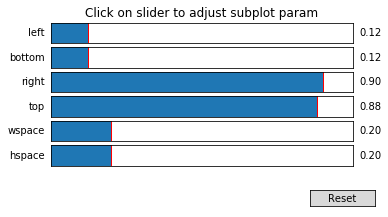

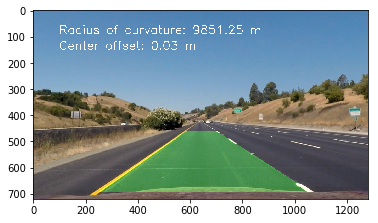

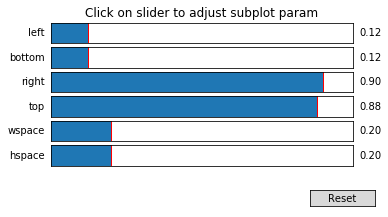

In [5]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

Left = Line()
Right = Line()

#global gLeftFit
#global gRightFit

#gLeftFit = None
#gRightFit = None

# Make a list of calibration images 
images = glob.glob('test_images/*.jpg')
randIndex = random.randint(0,len(images)-1)
img = cv2.imread(images[randIndex])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
laneimg = pipeline_image(img_rgb)
plt.imshow(laneimg)
plt.subplot_tool()
plt.show()

---

### Pipeline (video) 



In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left = Line()
Right = Line()

#global gLeftFit
#global gRightFit

#gLeftFit = None
#gRightFit = None

white_output = 'output_video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
print(clip1.fps)
white_clip = clip1.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

25.0

[MoviePy] >>>> Building video output_video/project_video.mp4


[MoviePy] Writing video output_video/project_video.mp4


  0%|                                                 | 0/1261 [00:00<?, ?it/s]

  0%|                                         | 1/1261 [00:00<06:52,  3.06it/s]

  0%|                                         | 2/1261 [00:00<07:04,  2.97it/s]

  0%|                                         | 3/1261 [00:01<07:10,  2.92it/s]

  0%|▏                                        | 4/1261 [00:01<07:06,  2.95it/s]

  0%|▏                                        | 5/1261 [00:01<06:58,  3.00it/s]

  0%|▏                                        | 6/1261 [00:02<06:56,  3.02it/s]

  1%|▏                                        | 7/1261 [00:02<06:42,  3.11it/s]

  1%|▎                                        | 8/1261 [00:02<06:29,  3.22it/s]

  1%|▎                                        | 9/1261 [00:02<06:24,  3.26it/s]

  1%|▎                                       | 10/1261 [00:03<06:21,  3.28it/s]

  1%|▎                                       | 11/1261 [00:03<06:18,  3.30it/s]

  1%|▍                                       | 12/1261 [00:03<06:12,  3.35it/s]

  1%|▍                                       | 13/1261 [00:04<06:11,  3.36it/s]

  1%|▍                                       | 14/1261 [00:04<06:05,  3.41it/s]

  1%|▍                                       | 15/1261 [00:04<06:01,  3.45it/s]

  1%|▌                                       | 16/1261 [00:04<05:58,  3.47it/s]

  1%|▌                                       | 17/1261 [00:05<06:02,  3.43it/s]

  1%|▌                                       | 18/1261 [00:05<06:01,  3.44it/s]

  2%|▌                                       | 19/1261 [00:05<05:59,  3.45it/s]

  2%|▋                                       | 20/1261 [00:06<06:03,  3.41it/s]

  2%|▋                                       | 21/1261 [00:06<05:57,  3.47it/s]

  2%|▋                                       | 22/1261 [00:06<06:06,  3.38it/s]

  2%|▋                                       | 23/1261 [00:06<06:06,  3.38it/s]

  2%|▊                                       | 24/1261 [00:07<06:09,  3.35it/s]

  2%|▊                                       | 25/1261 [00:07<06:06,  3.37it/s]

  2%|▊                                       | 26/1261 [00:07<06:01,  3.41it/s]

  2%|▊                                       | 27/1261 [00:08<05:57,  3.45it/s]

  2%|▉                                       | 28/1261 [00:08<06:00,  3.42it/s]

  2%|▉                                       | 29/1261 [00:08<05:59,  3.43it/s]

  2%|▉                                       | 30/1261 [00:09<06:03,  3.38it/s]

  2%|▉                                       | 31/1261 [00:09<06:06,  3.35it/s]

  3%|█                                       | 32/1261 [00:09<06:07,  3.34it/s]

  3%|█                                       | 33/1261 [00:09<06:05,  3.36it/s]

  3%|█                                       | 34/1261 [00:10<06:01,  3.39it/s]

  3%|█                                       | 35/1261 [00:10<06:05,  3.35it/s]

  3%|█▏                                      | 36/1261 [00:10<06:04,  3.36it/s]

  3%|█▏                                      | 37/1261 [00:11<05:58,  3.41it/s]

  3%|█▏                                      | 38/1261 [00:11<05:55,  3.44it/s]

  3%|█▏                                      | 39/1261 [00:11<06:10,  3.30it/s]

  3%|█▎                                      | 40/1261 [00:12<06:04,  3.35it/s]

  3%|█▎                                      | 41/1261 [00:12<06:01,  3.37it/s]

  3%|█▎                                      | 42/1261 [00:12<06:02,  3.36it/s]

  3%|█▎                                      | 43/1261 [00:12<06:10,  3.29it/s]

  3%|█▍                                      | 44/1261 [00:13<06:06,  3.32it/s]

  4%|█▍                                      | 45/1261 [00:13<06:10,  3.28it/s]

  4%|█▍                                      | 46/1261 [00:13<06:05,  3.32it/s]

  4%|█▍                                      | 47/1261 [00:14<06:03,  3.34it/s]

  4%|█▌                                      | 48/1261 [00:14<06:12,  3.26it/s]

  4%|█▌                                      | 49/1261 [00:14<06:13,  3.25it/s]

  4%|█▌                                      | 50/1261 [00:15<06:13,  3.24it/s]

  4%|█▌                                      | 51/1261 [00:15<06:17,  3.21it/s]

  4%|█▋                                      | 52/1261 [00:15<06:21,  3.17it/s]

  4%|█▋                                      | 53/1261 [00:16<06:18,  3.19it/s]

  4%|█▋                                      | 54/1261 [00:16<06:21,  3.16it/s]

  4%|█▋                                      | 55/1261 [00:16<06:33,  3.07it/s]

  4%|█▊                                      | 56/1261 [00:17<06:28,  3.10it/s]

  5%|█▊                                      | 57/1261 [00:17<06:36,  3.04it/s]

  5%|█▊                                      | 58/1261 [00:17<06:31,  3.08it/s]

  5%|█▊                                      | 59/1261 [00:18<06:31,  3.07it/s]

  5%|█▉                                      | 60/1261 [00:18<06:33,  3.05it/s]

  5%|█▉                                      | 61/1261 [00:18<06:29,  3.08it/s]

  5%|█▉                                      | 62/1261 [00:18<06:15,  3.20it/s]

  5%|█▉                                      | 63/1261 [00:19<06:08,  3.25it/s]

  5%|██                                      | 64/1261 [00:19<06:01,  3.31it/s]

  5%|██                                      | 65/1261 [00:19<06:03,  3.29it/s]

  5%|██                                      | 66/1261 [00:20<05:57,  3.34it/s]

  5%|██▏                                     | 67/1261 [00:20<05:52,  3.38it/s]

  5%|██▏                                     | 68/1261 [00:20<06:02,  3.29it/s]

  5%|██▏                                     | 69/1261 [00:21<06:01,  3.30it/s]

  6%|██▏                                     | 70/1261 [00:21<05:55,  3.35it/s]

  6%|██▎                                     | 71/1261 [00:21<05:51,  3.38it/s]

  6%|██▎                                     | 72/1261 [00:21<05:49,  3.40it/s]

  6%|██▎                                     | 73/1261 [00:22<05:57,  3.32it/s]

  6%|██▎                                     | 74/1261 [00:22<05:55,  3.34it/s]

  6%|██▍                                     | 75/1261 [00:22<05:58,  3.31it/s]

  6%|██▍                                     | 76/1261 [00:23<05:51,  3.38it/s]

  6%|██▍                                     | 77/1261 [00:23<05:55,  3.34it/s]

  6%|██▍                                     | 78/1261 [00:23<05:52,  3.35it/s]

  6%|██▌                                     | 79/1261 [00:24<05:52,  3.36it/s]

  6%|██▌                                     | 80/1261 [00:24<05:46,  3.41it/s]

  6%|██▌                                     | 81/1261 [00:24<05:47,  3.39it/s]

  7%|██▌                                     | 82/1261 [00:24<05:46,  3.40it/s]

  7%|██▋                                     | 83/1261 [00:25<05:47,  3.39it/s]

  7%|██▋                                     | 84/1261 [00:25<05:51,  3.35it/s]

  7%|██▋                                     | 85/1261 [00:25<05:51,  3.35it/s]

  7%|██▋                                     | 86/1261 [00:26<05:47,  3.38it/s]

  7%|██▊                                     | 87/1261 [00:26<05:49,  3.36it/s]

  7%|██▊                                     | 88/1261 [00:26<05:51,  3.34it/s]

  7%|██▊                                     | 89/1261 [00:26<05:58,  3.27it/s]

  7%|██▊                                     | 90/1261 [00:27<05:57,  3.28it/s]

  7%|██▉                                     | 91/1261 [00:27<06:02,  3.23it/s]

  7%|██▉                                     | 92/1261 [00:27<05:56,  3.28it/s]

  7%|██▉                                     | 93/1261 [00:28<05:51,  3.32it/s]

  7%|██▉                                     | 94/1261 [00:28<05:53,  3.30it/s]

  8%|███                                     | 95/1261 [00:28<05:49,  3.33it/s]

  8%|███                                     | 96/1261 [00:29<05:48,  3.34it/s]

  8%|███                                     | 97/1261 [00:29<05:45,  3.37it/s]

  8%|███                                     | 98/1261 [00:29<05:48,  3.34it/s]

  8%|███▏                                    | 99/1261 [00:29<05:44,  3.38it/s]

  8%|███                                    | 100/1261 [00:30<05:43,  3.38it/s]

  8%|███                                    | 101/1261 [00:30<05:43,  3.37it/s]

  8%|███▏                                   | 102/1261 [00:30<05:43,  3.37it/s]

  8%|███▏                                   | 103/1261 [00:31<05:43,  3.38it/s]

  8%|███▏                                   | 104/1261 [00:31<05:47,  3.33it/s]

  8%|███▏                                   | 105/1261 [00:31<05:47,  3.33it/s]

  8%|███▎                                   | 106/1261 [00:32<05:40,  3.39it/s]

  8%|███▎                                   | 107/1261 [00:32<05:39,  3.39it/s]

  9%|███▎                                   | 108/1261 [00:32<05:37,  3.42it/s]

  9%|███▎                                   | 109/1261 [00:32<05:45,  3.34it/s]

  9%|███▍                                   | 110/1261 [00:33<05:43,  3.35it/s]

  9%|███▍                                   | 111/1261 [00:33<05:45,  3.32it/s]

  9%|███▍                                   | 112/1261 [00:33<05:48,  3.30it/s]

  9%|███▍                                   | 113/1261 [00:34<05:48,  3.29it/s]

  9%|███▌                                   | 114/1261 [00:34<05:48,  3.29it/s]

  9%|███▌                                   | 115/1261 [00:34<05:44,  3.32it/s]

  9%|███▌                                   | 116/1261 [00:35<05:44,  3.33it/s]

  9%|███▌                                   | 117/1261 [00:35<05:46,  3.30it/s]

  9%|███▋                                   | 118/1261 [00:35<05:45,  3.31it/s]

  9%|███▋                                   | 119/1261 [00:35<05:41,  3.34it/s]

 10%|███▋                                   | 120/1261 [00:36<05:38,  3.37it/s]

 10%|███▋                                   | 121/1261 [00:36<05:44,  3.31it/s]

 10%|███▊                                   | 122/1261 [00:36<05:42,  3.33it/s]

 10%|███▊                                   | 123/1261 [00:37<05:37,  3.37it/s]

 10%|███▊                                   | 124/1261 [00:37<05:39,  3.35it/s]

 10%|███▊                                   | 125/1261 [00:37<05:35,  3.39it/s]

 10%|███▉                                   | 126/1261 [00:38<05:44,  3.30it/s]

 10%|███▉                                   | 127/1261 [00:38<05:42,  3.31it/s]

 10%|███▉                                   | 128/1261 [00:38<05:39,  3.34it/s]

 10%|███▉                                   | 129/1261 [00:38<05:37,  3.35it/s]

 10%|████                                   | 130/1261 [00:39<05:36,  3.36it/s]

 10%|████                                   | 131/1261 [00:39<05:34,  3.38it/s]

 10%|████                                   | 132/1261 [00:39<05:38,  3.34it/s]

 11%|████                                   | 133/1261 [00:40<05:35,  3.36it/s]

 11%|████▏                                  | 134/1261 [00:40<05:35,  3.36it/s]

 11%|████▏                                  | 135/1261 [00:40<05:36,  3.35it/s]

 11%|████▏                                  | 136/1261 [00:41<05:37,  3.34it/s]

 11%|████▏                                  | 137/1261 [00:41<05:41,  3.29it/s]

 11%|████▎                                  | 138/1261 [00:41<05:45,  3.25it/s]

 11%|████▎                                  | 139/1261 [00:42<05:47,  3.23it/s]

 11%|████▎                                  | 140/1261 [00:42<05:40,  3.29it/s]

 11%|████▎                                  | 141/1261 [00:42<05:40,  3.29it/s]

 11%|████▍                                  | 142/1261 [00:42<05:36,  3.32it/s]

 11%|████▍                                  | 143/1261 [00:43<05:35,  3.34it/s]

 11%|████▍                                  | 144/1261 [00:43<05:33,  3.35it/s]

 11%|████▍                                  | 145/1261 [00:43<05:39,  3.29it/s]

 12%|████▌                                  | 146/1261 [00:44<05:35,  3.33it/s]

 12%|████▌                                  | 147/1261 [00:44<05:31,  3.36it/s]

 12%|████▌                                  | 148/1261 [00:44<05:36,  3.31it/s]

 12%|████▌                                  | 149/1261 [00:44<05:30,  3.37it/s]

 12%|████▋                                  | 150/1261 [00:45<05:34,  3.32it/s]

 12%|████▋                                  | 151/1261 [00:45<05:41,  3.25it/s]

 12%|████▋                                  | 152/1261 [00:45<05:38,  3.28it/s]

 12%|████▋                                  | 153/1261 [00:46<05:35,  3.31it/s]

 12%|████▊                                  | 154/1261 [00:46<05:32,  3.33it/s]

 12%|████▊                                  | 155/1261 [00:46<05:33,  3.32it/s]

 12%|████▊                                  | 156/1261 [00:47<05:30,  3.34it/s]

 12%|████▊                                  | 157/1261 [00:47<05:27,  3.37it/s]

 13%|████▉                                  | 158/1261 [00:47<05:28,  3.36it/s]

 13%|████▉                                  | 159/1261 [00:47<05:27,  3.36it/s]

 13%|████▉                                  | 160/1261 [00:48<05:21,  3.42it/s]

 13%|████▉                                  | 161/1261 [00:48<05:22,  3.41it/s]

 13%|█████                                  | 162/1261 [00:48<05:30,  3.32it/s]

 13%|█████                                  | 163/1261 [00:49<05:33,  3.29it/s]

 13%|█████                                  | 164/1261 [00:49<05:31,  3.31it/s]

 13%|█████                                  | 165/1261 [00:49<05:33,  3.29it/s]

 13%|█████▏                                 | 166/1261 [00:50<05:32,  3.30it/s]

 13%|█████▏                                 | 167/1261 [00:50<05:25,  3.36it/s]

 13%|█████▏                                 | 168/1261 [00:50<05:30,  3.30it/s]

 13%|█████▏                                 | 169/1261 [00:51<05:28,  3.32it/s]

 13%|█████▎                                 | 170/1261 [00:51<05:23,  3.38it/s]

 14%|█████▎                                 | 171/1261 [00:51<05:22,  3.38it/s]

 14%|█████▎                                 | 172/1261 [00:51<05:27,  3.33it/s]

 14%|█████▎                                 | 173/1261 [00:52<05:26,  3.33it/s]

 14%|█████▍                                 | 174/1261 [00:52<05:29,  3.30it/s]

 14%|█████▍                                 | 175/1261 [00:52<05:28,  3.30it/s]

 14%|█████▍                                 | 176/1261 [00:53<05:27,  3.31it/s]

 14%|█████▍                                 | 177/1261 [00:53<05:25,  3.33it/s]

 14%|█████▌                                 | 178/1261 [00:53<05:39,  3.19it/s]

 14%|█████▌                                 | 179/1261 [00:54<05:35,  3.23it/s]

 14%|█████▌                                 | 180/1261 [00:54<05:30,  3.27it/s]

 14%|█████▌                                 | 181/1261 [00:54<05:30,  3.27it/s]

 14%|█████▋                                 | 182/1261 [00:54<05:25,  3.32it/s]

 15%|█████▋                                 | 183/1261 [00:55<05:22,  3.34it/s]

 15%|█████▋                                 | 184/1261 [00:55<05:16,  3.40it/s]

 15%|█████▋                                 | 185/1261 [00:55<05:13,  3.43it/s]

 15%|█████▊                                 | 186/1261 [00:56<05:18,  3.38it/s]

 15%|█████▊                                 | 187/1261 [00:56<05:13,  3.42it/s]

 15%|█████▊                                 | 188/1261 [00:56<05:16,  3.39it/s]

 15%|█████▊                                 | 189/1261 [00:56<05:14,  3.41it/s]

 15%|█████▉                                 | 190/1261 [00:57<05:16,  3.38it/s]

 15%|█████▉                                 | 191/1261 [00:57<05:18,  3.36it/s]

 15%|█████▉                                 | 192/1261 [00:57<05:18,  3.36it/s]

 15%|█████▉                                 | 193/1261 [00:58<05:19,  3.34it/s]

 15%|██████                                 | 194/1261 [00:58<05:20,  3.33it/s]

 15%|██████                                 | 195/1261 [00:58<05:19,  3.34it/s]

 16%|██████                                 | 196/1261 [00:59<05:24,  3.28it/s]

 16%|██████                                 | 197/1261 [00:59<05:19,  3.33it/s]

 16%|██████                                 | 198/1261 [00:59<05:16,  3.36it/s]

 16%|██████▏                                | 199/1261 [00:59<05:14,  3.38it/s]

 16%|██████▏                                | 200/1261 [01:00<05:16,  3.36it/s]

 16%|██████▏                                | 201/1261 [01:00<05:15,  3.36it/s]

 16%|██████▏                                | 202/1261 [01:00<05:14,  3.37it/s]

 16%|██████▎                                | 203/1261 [01:01<05:16,  3.34it/s]

 16%|██████▎                                | 204/1261 [01:01<05:14,  3.36it/s]

 16%|██████▎                                | 205/1261 [01:01<05:12,  3.38it/s]

 16%|██████▎                                | 206/1261 [01:02<05:11,  3.38it/s]

 16%|██████▍                                | 207/1261 [01:02<05:11,  3.39it/s]

 16%|██████▍                                | 208/1261 [01:02<05:16,  3.33it/s]

 17%|██████▍                                | 209/1261 [01:02<05:13,  3.35it/s]

 17%|██████▍                                | 210/1261 [01:03<05:10,  3.38it/s]

 17%|██████▌                                | 211/1261 [01:03<05:21,  3.27it/s]

 17%|██████▌                                | 212/1261 [01:03<05:18,  3.29it/s]

 17%|██████▌                                | 213/1261 [01:04<05:21,  3.26it/s]

 17%|██████▌                                | 214/1261 [01:04<05:18,  3.29it/s]

 17%|██████▋                                | 215/1261 [01:04<05:13,  3.33it/s]

 17%|██████▋                                | 216/1261 [01:05<05:15,  3.31it/s]

 17%|██████▋                                | 217/1261 [01:05<05:12,  3.34it/s]

 17%|██████▋                                | 218/1261 [01:05<05:13,  3.33it/s]

 17%|██████▊                                | 219/1261 [01:05<05:11,  3.34it/s]

 17%|██████▊                                | 220/1261 [01:06<05:10,  3.35it/s]

 18%|██████▊                                | 221/1261 [01:06<05:09,  3.36it/s]

 18%|██████▊                                | 222/1261 [01:06<05:09,  3.36it/s]

 18%|██████▉                                | 223/1261 [01:07<05:05,  3.40it/s]

 18%|██████▉                                | 224/1261 [01:07<05:05,  3.40it/s]

 18%|██████▉                                | 225/1261 [01:07<05:05,  3.39it/s]

 18%|██████▉                                | 226/1261 [01:08<05:06,  3.37it/s]

 18%|███████                                | 227/1261 [01:08<05:07,  3.37it/s]

 18%|███████                                | 228/1261 [01:08<05:07,  3.36it/s]

 18%|███████                                | 229/1261 [01:08<05:11,  3.31it/s]

 18%|███████                                | 230/1261 [01:09<05:12,  3.30it/s]

 18%|███████▏                               | 231/1261 [01:09<05:07,  3.35it/s]

 18%|███████▏                               | 232/1261 [01:09<05:15,  3.26it/s]

 18%|███████▏                               | 233/1261 [01:10<05:12,  3.29it/s]

 19%|███████▏                               | 234/1261 [01:10<05:17,  3.23it/s]

 19%|███████▎                               | 235/1261 [01:10<05:17,  3.23it/s]

 19%|███████▎                               | 236/1261 [01:11<05:11,  3.29it/s]

 19%|███████▎                               | 237/1261 [01:11<05:07,  3.33it/s]

 19%|███████▎                               | 238/1261 [01:11<05:08,  3.32it/s]

 19%|███████▍                               | 239/1261 [01:11<05:07,  3.33it/s]

 19%|███████▍                               | 240/1261 [01:12<05:10,  3.29it/s]

 19%|███████▍                               | 241/1261 [01:12<05:08,  3.31it/s]

 19%|███████▍                               | 242/1261 [01:12<05:05,  3.34it/s]

 19%|███████▌                               | 243/1261 [01:13<05:00,  3.38it/s]

 19%|███████▌                               | 244/1261 [01:13<04:58,  3.41it/s]

 19%|███████▌                               | 245/1261 [01:13<05:06,  3.31it/s]

 20%|███████▌                               | 246/1261 [01:14<05:05,  3.32it/s]

 20%|███████▋                               | 247/1261 [01:14<05:01,  3.36it/s]

 20%|███████▋                               | 248/1261 [01:14<04:59,  3.39it/s]

 20%|███████▋                               | 249/1261 [01:14<04:57,  3.40it/s]

 20%|███████▋                               | 250/1261 [01:15<04:57,  3.39it/s]

 20%|███████▊                               | 251/1261 [01:15<05:02,  3.34it/s]

 20%|███████▊                               | 252/1261 [01:15<04:59,  3.37it/s]

 20%|███████▊                               | 253/1261 [01:16<05:03,  3.32it/s]

 20%|███████▊                               | 254/1261 [01:16<05:07,  3.27it/s]

 20%|███████▉                               | 255/1261 [01:16<05:08,  3.26it/s]

 20%|███████▉                               | 256/1261 [01:17<05:10,  3.24it/s]

 20%|███████▉                               | 257/1261 [01:17<05:06,  3.27it/s]

 20%|███████▉                               | 258/1261 [01:17<05:05,  3.29it/s]

 21%|████████                               | 259/1261 [01:18<05:08,  3.25it/s]

 21%|████████                               | 260/1261 [01:18<05:04,  3.29it/s]

 21%|████████                               | 261/1261 [01:18<05:07,  3.25it/s]

 21%|████████                               | 262/1261 [01:18<05:07,  3.25it/s]

 21%|████████▏                              | 263/1261 [01:19<05:07,  3.24it/s]

 21%|████████▏                              | 264/1261 [01:19<05:02,  3.29it/s]

 21%|████████▏                              | 265/1261 [01:19<04:59,  3.33it/s]

 21%|████████▏                              | 266/1261 [01:20<05:02,  3.29it/s]

 21%|████████▎                              | 267/1261 [01:20<05:04,  3.27it/s]

 21%|████████▎                              | 268/1261 [01:20<05:02,  3.28it/s]

 21%|████████▎                              | 269/1261 [01:21<04:56,  3.34it/s]

 21%|████████▎                              | 270/1261 [01:21<04:57,  3.33it/s]

 21%|████████▍                              | 271/1261 [01:21<05:02,  3.28it/s]

 22%|████████▍                              | 272/1261 [01:21<04:58,  3.32it/s]

 22%|████████▍                              | 273/1261 [01:22<05:02,  3.27it/s]

 22%|████████▍                              | 274/1261 [01:22<05:03,  3.26it/s]

 22%|████████▌                              | 275/1261 [01:22<04:59,  3.29it/s]

 22%|████████▌                              | 276/1261 [01:23<04:56,  3.32it/s]

 22%|████████▌                              | 277/1261 [01:23<04:55,  3.32it/s]

 22%|████████▌                              | 278/1261 [01:23<04:54,  3.34it/s]

 22%|████████▋                              | 279/1261 [01:24<04:51,  3.37it/s]

 22%|████████▋                              | 280/1261 [01:24<04:53,  3.34it/s]

 22%|████████▋                              | 281/1261 [01:24<04:55,  3.32it/s]

 22%|████████▋                              | 282/1261 [01:24<04:59,  3.27it/s]

 22%|████████▊                              | 283/1261 [01:25<04:56,  3.29it/s]

 23%|████████▊                              | 284/1261 [01:25<05:02,  3.23it/s]

 23%|████████▊                              | 285/1261 [01:25<04:55,  3.31it/s]

 23%|████████▊                              | 286/1261 [01:26<04:51,  3.34it/s]

 23%|████████▉                              | 287/1261 [01:26<04:49,  3.36it/s]

 23%|████████▉                              | 288/1261 [01:26<04:58,  3.26it/s]

 23%|████████▉                              | 289/1261 [01:27<05:01,  3.23it/s]

 23%|████████▉                              | 290/1261 [01:27<04:55,  3.28it/s]

 23%|█████████                              | 291/1261 [01:27<04:57,  3.26it/s]

 23%|█████████                              | 292/1261 [01:28<04:56,  3.27it/s]

 23%|█████████                              | 293/1261 [01:28<04:55,  3.28it/s]

 23%|█████████                              | 294/1261 [01:28<04:59,  3.23it/s]

 23%|█████████                              | 295/1261 [01:28<04:59,  3.22it/s]

 23%|█████████▏                             | 296/1261 [01:29<04:57,  3.24it/s]

 24%|█████████▏                             | 297/1261 [01:29<04:57,  3.24it/s]

 24%|█████████▏                             | 298/1261 [01:29<04:57,  3.24it/s]

 24%|█████████▏                             | 299/1261 [01:30<04:58,  3.22it/s]

 24%|█████████▎                             | 300/1261 [01:30<05:06,  3.13it/s]

 24%|█████████▎                             | 301/1261 [01:30<05:02,  3.17it/s]

 24%|█████████▎                             | 302/1261 [01:31<05:01,  3.18it/s]

 24%|█████████▎                             | 303/1261 [01:31<05:01,  3.18it/s]

 24%|█████████▍                             | 304/1261 [01:31<04:59,  3.20it/s]

 24%|█████████▍                             | 305/1261 [01:32<04:52,  3.27it/s]

 24%|█████████▍                             | 306/1261 [01:32<04:48,  3.32it/s]

 24%|█████████▍                             | 307/1261 [01:32<04:44,  3.35it/s]

 24%|█████████▌                             | 308/1261 [01:32<04:44,  3.35it/s]

 25%|█████████▌                             | 309/1261 [01:33<04:44,  3.35it/s]

 25%|█████████▌                             | 310/1261 [01:33<04:41,  3.38it/s]

 25%|█████████▌                             | 311/1261 [01:33<04:44,  3.34it/s]

 25%|█████████▋                             | 312/1261 [01:34<04:42,  3.36it/s]

 25%|█████████▋                             | 313/1261 [01:34<04:41,  3.37it/s]

 25%|█████████▋                             | 314/1261 [01:34<04:51,  3.25it/s]

 25%|█████████▋                             | 315/1261 [01:35<04:51,  3.24it/s]

 25%|█████████▊                             | 316/1261 [01:35<04:52,  3.23it/s]

 25%|█████████▊                             | 317/1261 [01:35<04:52,  3.22it/s]

 25%|█████████▊                             | 318/1261 [01:36<04:55,  3.19it/s]

 25%|█████████▊                             | 319/1261 [01:36<04:48,  3.27it/s]

 25%|█████████▉                             | 320/1261 [01:36<04:51,  3.23it/s]

 25%|█████████▉                             | 321/1261 [01:36<04:55,  3.18it/s]

 26%|█████████▉                             | 322/1261 [01:37<04:55,  3.18it/s]

 26%|█████████▉                             | 323/1261 [01:37<04:57,  3.15it/s]

 26%|██████████                             | 324/1261 [01:37<04:47,  3.26it/s]

 26%|██████████                             | 325/1261 [01:38<04:54,  3.18it/s]

 26%|██████████                             | 326/1261 [01:38<04:49,  3.23it/s]

 26%|██████████                             | 327/1261 [01:38<04:49,  3.23it/s]

 26%|██████████▏                            | 328/1261 [01:39<04:45,  3.26it/s]

 26%|██████████▏                            | 329/1261 [01:39<04:41,  3.31it/s]

 26%|██████████▏                            | 330/1261 [01:39<04:45,  3.26it/s]

 26%|██████████▏                            | 331/1261 [01:40<04:48,  3.22it/s]

 26%|██████████▎                            | 332/1261 [01:40<04:47,  3.24it/s]

 26%|██████████▎                            | 333/1261 [01:40<04:42,  3.28it/s]

 26%|██████████▎                            | 334/1261 [01:40<04:41,  3.30it/s]

 27%|██████████▎                            | 335/1261 [01:41<04:45,  3.24it/s]

 27%|██████████▍                            | 336/1261 [01:41<04:43,  3.27it/s]

 27%|██████████▍                            | 337/1261 [01:41<04:42,  3.27it/s]

 27%|██████████▍                            | 338/1261 [01:42<04:45,  3.24it/s]

 27%|██████████▍                            | 339/1261 [01:42<04:47,  3.21it/s]

 27%|██████████▌                            | 340/1261 [01:42<04:44,  3.24it/s]

 27%|██████████▌                            | 341/1261 [01:43<04:40,  3.28it/s]

 27%|██████████▌                            | 342/1261 [01:43<04:40,  3.27it/s]

 27%|██████████▌                            | 343/1261 [01:43<04:41,  3.26it/s]

 27%|██████████▋                            | 344/1261 [01:44<04:38,  3.29it/s]

 27%|██████████▋                            | 345/1261 [01:44<04:37,  3.30it/s]

 27%|██████████▋                            | 346/1261 [01:44<04:36,  3.31it/s]

 28%|██████████▋                            | 347/1261 [01:44<04:41,  3.25it/s]

 28%|██████████▊                            | 348/1261 [01:45<04:37,  3.29it/s]

 28%|██████████▊                            | 349/1261 [01:45<04:45,  3.20it/s]

 28%|██████████▊                            | 350/1261 [01:45<04:40,  3.25it/s]

 28%|██████████▊                            | 351/1261 [01:46<04:37,  3.28it/s]

 28%|██████████▉                            | 352/1261 [01:46<04:33,  3.33it/s]

 28%|██████████▉                            | 353/1261 [01:46<04:33,  3.32it/s]

 28%|██████████▉                            | 354/1261 [01:47<04:30,  3.35it/s]

 28%|██████████▉                            | 355/1261 [01:47<04:36,  3.28it/s]

 28%|███████████                            | 356/1261 [01:47<04:35,  3.29it/s]

 28%|███████████                            | 357/1261 [01:47<04:32,  3.31it/s]

 28%|███████████                            | 358/1261 [01:48<04:28,  3.37it/s]

 28%|███████████                            | 359/1261 [01:48<04:31,  3.32it/s]

 29%|███████████▏                           | 360/1261 [01:48<04:30,  3.33it/s]

 29%|███████████▏                           | 361/1261 [01:49<04:36,  3.26it/s]

 29%|███████████▏                           | 362/1261 [01:49<04:32,  3.30it/s]

 29%|███████████▏                           | 363/1261 [01:49<04:31,  3.30it/s]

 29%|███████████▎                           | 364/1261 [01:50<04:29,  3.32it/s]

 29%|███████████▎                           | 365/1261 [01:50<04:28,  3.34it/s]

 29%|███████████▎                           | 366/1261 [01:50<04:35,  3.25it/s]

 29%|███████████▎                           | 367/1261 [01:51<04:33,  3.26it/s]

 29%|███████████▍                           | 368/1261 [01:51<04:34,  3.25it/s]

 29%|███████████▍                           | 369/1261 [01:51<04:29,  3.31it/s]

 29%|███████████▍                           | 370/1261 [01:51<04:33,  3.26it/s]

 29%|███████████▍                           | 371/1261 [01:52<04:35,  3.23it/s]

 30%|███████████▌                           | 372/1261 [01:52<04:31,  3.28it/s]

 30%|███████████▌                           | 373/1261 [01:52<04:27,  3.32it/s]

 30%|███████████▌                           | 374/1261 [01:53<04:27,  3.31it/s]

 30%|███████████▌                           | 375/1261 [01:53<04:30,  3.28it/s]

 30%|███████████▋                           | 376/1261 [01:53<04:34,  3.22it/s]

 30%|███████████▋                           | 377/1261 [01:54<04:31,  3.25it/s]

 30%|███████████▋                           | 378/1261 [01:54<04:27,  3.30it/s]

 30%|███████████▋                           | 379/1261 [01:54<04:27,  3.30it/s]

 30%|███████████▊                           | 380/1261 [01:54<04:23,  3.34it/s]

 30%|███████████▊                           | 381/1261 [01:55<04:22,  3.35it/s]

 30%|███████████▊                           | 382/1261 [01:55<04:22,  3.34it/s]

 30%|███████████▊                           | 383/1261 [01:55<04:26,  3.30it/s]

 30%|███████████▉                           | 384/1261 [01:56<04:28,  3.26it/s]

 31%|███████████▉                           | 385/1261 [01:56<04:31,  3.23it/s]

 31%|███████████▉                           | 386/1261 [01:56<04:31,  3.22it/s]

 31%|███████████▉                           | 387/1261 [01:57<04:25,  3.29it/s]

 31%|████████████                           | 388/1261 [01:57<04:24,  3.30it/s]

 31%|████████████                           | 389/1261 [01:57<04:28,  3.25it/s]

 31%|████████████                           | 390/1261 [01:58<04:23,  3.31it/s]

 31%|████████████                           | 391/1261 [01:58<04:24,  3.29it/s]

 31%|████████████                           | 392/1261 [01:58<04:27,  3.25it/s]

 31%|████████████▏                          | 393/1261 [01:58<04:25,  3.27it/s]

 31%|████████████▏                          | 394/1261 [01:59<04:20,  3.33it/s]

 31%|████████████▏                          | 395/1261 [01:59<04:19,  3.34it/s]

 31%|████████████▏                          | 396/1261 [01:59<04:21,  3.31it/s]

 31%|████████████▎                          | 397/1261 [02:00<04:26,  3.24it/s]

 32%|████████████▎                          | 398/1261 [02:00<04:28,  3.22it/s]

 32%|████████████▎                          | 399/1261 [02:00<04:25,  3.24it/s]

 32%|████████████▎                          | 400/1261 [02:01<04:24,  3.25it/s]

 32%|████████████▍                          | 401/1261 [02:01<04:24,  3.26it/s]

 32%|████████████▍                          | 402/1261 [02:01<04:27,  3.21it/s]

 32%|████████████▍                          | 403/1261 [02:02<04:22,  3.27it/s]

 32%|████████████▍                          | 404/1261 [02:02<04:21,  3.27it/s]

 32%|████████████▌                          | 405/1261 [02:02<04:19,  3.30it/s]

 32%|████████████▌                          | 406/1261 [02:02<04:16,  3.33it/s]

 32%|████████████▌                          | 407/1261 [02:03<04:15,  3.34it/s]

 32%|████████████▌                          | 408/1261 [02:03<04:15,  3.34it/s]

 32%|████████████▋                          | 409/1261 [02:03<04:17,  3.30it/s]

 33%|████████████▋                          | 410/1261 [02:04<04:17,  3.30it/s]

 33%|████████████▋                          | 411/1261 [02:04<04:19,  3.27it/s]

 33%|████████████▋                          | 412/1261 [02:04<04:17,  3.30it/s]

 33%|████████████▊                          | 413/1261 [02:05<04:16,  3.30it/s]

 33%|████████████▊                          | 414/1261 [02:05<04:19,  3.27it/s]

 33%|████████████▊                          | 415/1261 [02:05<04:17,  3.28it/s]

 33%|████████████▊                          | 416/1261 [02:05<04:16,  3.29it/s]

 33%|████████████▉                          | 417/1261 [02:06<04:15,  3.31it/s]

 33%|████████████▉                          | 418/1261 [02:06<04:14,  3.31it/s]

 33%|████████████▉                          | 419/1261 [02:06<04:14,  3.30it/s]

 33%|████████████▉                          | 420/1261 [02:07<04:17,  3.27it/s]

 33%|█████████████                          | 421/1261 [02:07<04:15,  3.28it/s]

 33%|█████████████                          | 422/1261 [02:07<04:14,  3.29it/s]

 34%|█████████████                          | 423/1261 [02:08<04:14,  3.30it/s]

 34%|█████████████                          | 424/1261 [02:08<04:17,  3.25it/s]

 34%|█████████████▏                         | 425/1261 [02:08<04:19,  3.22it/s]

 34%|█████████████▏                         | 426/1261 [02:09<04:20,  3.20it/s]

 34%|█████████████▏                         | 427/1261 [02:09<04:19,  3.21it/s]

 34%|█████████████▏                         | 428/1261 [02:09<04:18,  3.22it/s]

 34%|█████████████▎                         | 429/1261 [02:09<04:16,  3.25it/s]

 34%|█████████████▎                         | 430/1261 [02:10<04:23,  3.15it/s]

 34%|█████████████▎                         | 431/1261 [02:10<04:19,  3.20it/s]

 34%|█████████████▎                         | 432/1261 [02:10<04:19,  3.19it/s]

 34%|█████████████▍                         | 433/1261 [02:11<04:16,  3.23it/s]

 34%|█████████████▍                         | 434/1261 [02:11<04:12,  3.27it/s]

 34%|█████████████▍                         | 435/1261 [02:11<04:11,  3.28it/s]

 35%|█████████████▍                         | 436/1261 [02:12<04:10,  3.29it/s]

 35%|█████████████▌                         | 437/1261 [02:12<04:08,  3.32it/s]

 35%|█████████████▌                         | 438/1261 [02:12<04:10,  3.28it/s]

 35%|█████████████▌                         | 439/1261 [02:12<04:08,  3.31it/s]

 35%|█████████████▌                         | 440/1261 [02:13<04:08,  3.31it/s]

 35%|█████████████▋                         | 441/1261 [02:13<04:06,  3.32it/s]

 35%|█████████████▋                         | 442/1261 [02:13<04:05,  3.33it/s]

 35%|█████████████▋                         | 443/1261 [02:14<04:07,  3.31it/s]

 35%|█████████████▋                         | 444/1261 [02:14<04:07,  3.30it/s]

 35%|█████████████▊                         | 445/1261 [02:14<04:09,  3.27it/s]

 35%|█████████████▊                         | 446/1261 [02:15<04:05,  3.32it/s]

 35%|█████████████▊                         | 447/1261 [02:15<04:10,  3.25it/s]

 36%|█████████████▊                         | 448/1261 [02:15<04:06,  3.30it/s]

 36%|█████████████▉                         | 449/1261 [02:16<04:04,  3.33it/s]

 36%|█████████████▉                         | 450/1261 [02:16<04:01,  3.35it/s]

 36%|█████████████▉                         | 451/1261 [02:16<04:04,  3.32it/s]

 36%|█████████████▉                         | 452/1261 [02:16<04:09,  3.24it/s]

 36%|██████████████                         | 453/1261 [02:17<04:08,  3.25it/s]

 36%|██████████████                         | 454/1261 [02:17<04:10,  3.22it/s]

 36%|██████████████                         | 455/1261 [02:17<04:07,  3.26it/s]

 36%|██████████████                         | 456/1261 [02:18<04:09,  3.22it/s]

 36%|██████████████▏                        | 457/1261 [02:18<04:04,  3.28it/s]

 36%|██████████████▏                        | 458/1261 [02:18<04:03,  3.30it/s]

 36%|██████████████▏                        | 459/1261 [02:19<04:02,  3.30it/s]

 36%|██████████████▏                        | 460/1261 [02:19<04:00,  3.33it/s]

 37%|██████████████▎                        | 461/1261 [02:19<03:59,  3.34it/s]

 37%|██████████████▎                        | 462/1261 [02:19<04:03,  3.28it/s]

 37%|██████████████▎                        | 463/1261 [02:20<04:05,  3.25it/s]

 37%|██████████████▎                        | 464/1261 [02:20<04:07,  3.22it/s]

 37%|██████████████▍                        | 465/1261 [02:20<04:11,  3.17it/s]

 37%|██████████████▍                        | 466/1261 [02:21<04:09,  3.19it/s]

 37%|██████████████▍                        | 467/1261 [02:21<04:04,  3.25it/s]

 37%|██████████████▍                        | 468/1261 [02:21<04:04,  3.24it/s]

 37%|██████████████▌                        | 469/1261 [02:22<04:02,  3.27it/s]

 37%|██████████████▌                        | 470/1261 [02:22<03:58,  3.31it/s]

 37%|██████████████▌                        | 471/1261 [02:22<03:57,  3.32it/s]

 37%|██████████████▌                        | 472/1261 [02:23<03:57,  3.32it/s]

 38%|██████████████▋                        | 473/1261 [02:23<03:58,  3.30it/s]

 38%|██████████████▋                        | 474/1261 [02:23<03:58,  3.29it/s]

 38%|██████████████▋                        | 475/1261 [02:23<03:54,  3.36it/s]

 38%|██████████████▋                        | 476/1261 [02:24<03:54,  3.34it/s]

 38%|██████████████▊                        | 477/1261 [02:24<03:54,  3.34it/s]

 38%|██████████████▊                        | 478/1261 [02:24<03:57,  3.30it/s]

 38%|██████████████▊                        | 479/1261 [02:25<04:00,  3.25it/s]

 38%|██████████████▊                        | 480/1261 [02:25<04:03,  3.21it/s]

 38%|██████████████▉                        | 481/1261 [02:25<04:07,  3.15it/s]

 38%|██████████████▉                        | 482/1261 [02:26<04:06,  3.16it/s]

 38%|██████████████▉                        | 483/1261 [02:26<04:06,  3.16it/s]

 38%|██████████████▉                        | 484/1261 [02:26<04:06,  3.15it/s]

 38%|███████████████                        | 485/1261 [02:27<04:02,  3.20it/s]

 39%|███████████████                        | 486/1261 [02:27<04:00,  3.23it/s]

 39%|███████████████                        | 487/1261 [02:27<03:55,  3.29it/s]

 39%|███████████████                        | 488/1261 [02:28<04:00,  3.21it/s]

 39%|███████████████                        | 489/1261 [02:28<03:59,  3.22it/s]

 39%|███████████████▏                       | 490/1261 [02:28<03:59,  3.21it/s]

 39%|███████████████▏                       | 491/1261 [02:28<03:57,  3.24it/s]

 39%|███████████████▏                       | 492/1261 [02:29<03:59,  3.21it/s]

 39%|███████████████▏                       | 493/1261 [02:29<04:00,  3.19it/s]

 39%|███████████████▎                       | 494/1261 [02:29<04:02,  3.16it/s]

 39%|███████████████▎                       | 495/1261 [02:30<03:59,  3.19it/s]

 39%|███████████████▎                       | 496/1261 [02:30<03:58,  3.21it/s]

 39%|███████████████▎                       | 497/1261 [02:30<03:53,  3.27it/s]

 39%|███████████████▍                       | 498/1261 [02:31<03:58,  3.19it/s]

 40%|███████████████▍                       | 499/1261 [02:31<04:01,  3.15it/s]

 40%|███████████████▍                       | 500/1261 [02:31<04:00,  3.17it/s]

 40%|███████████████▍                       | 501/1261 [02:32<03:55,  3.23it/s]

 40%|███████████████▌                       | 502/1261 [02:32<03:55,  3.22it/s]

 40%|███████████████▌                       | 503/1261 [02:32<03:59,  3.17it/s]

 40%|███████████████▌                       | 504/1261 [02:33<04:00,  3.15it/s]

 40%|███████████████▌                       | 505/1261 [02:33<04:01,  3.12it/s]

 40%|███████████████▋                       | 506/1261 [02:33<04:03,  3.10it/s]

 40%|███████████████▋                       | 507/1261 [02:33<04:00,  3.14it/s]

 40%|███████████████▋                       | 508/1261 [02:34<03:58,  3.15it/s]

 40%|███████████████▋                       | 509/1261 [02:34<03:54,  3.20it/s]

 40%|███████████████▊                       | 510/1261 [02:34<03:58,  3.15it/s]

 41%|███████████████▊                       | 511/1261 [02:35<03:56,  3.18it/s]

 41%|███████████████▊                       | 512/1261 [02:35<03:52,  3.22it/s]

 41%|███████████████▊                       | 513/1261 [02:35<03:56,  3.16it/s]

 41%|███████████████▉                       | 514/1261 [02:36<03:56,  3.15it/s]

 41%|███████████████▉                       | 515/1261 [02:36<03:55,  3.17it/s]

 41%|███████████████▉                       | 516/1261 [02:36<03:54,  3.18it/s]

 41%|███████████████▉                       | 517/1261 [02:37<03:55,  3.16it/s]

 41%|████████████████                       | 518/1261 [02:37<03:52,  3.20it/s]

 41%|████████████████                       | 519/1261 [02:37<03:51,  3.21it/s]

 41%|████████████████                       | 520/1261 [02:38<03:53,  3.17it/s]

 41%|████████████████                       | 521/1261 [02:38<03:55,  3.15it/s]

 41%|████████████████▏                      | 522/1261 [02:38<03:52,  3.17it/s]

 41%|████████████████▏                      | 523/1261 [02:39<03:49,  3.21it/s]

 42%|████████████████▏                      | 524/1261 [02:39<03:48,  3.23it/s]

 42%|████████████████▏                      | 525/1261 [02:39<03:49,  3.21it/s]

 42%|████████████████▎                      | 526/1261 [02:39<03:48,  3.22it/s]

 42%|████████████████▎                      | 527/1261 [02:40<03:46,  3.24it/s]

 42%|████████████████▎                      | 528/1261 [02:40<03:50,  3.18it/s]

 42%|████████████████▎                      | 529/1261 [02:40<03:47,  3.22it/s]

 42%|████████████████▍                      | 530/1261 [02:41<03:46,  3.23it/s]

 42%|████████████████▍                      | 531/1261 [02:41<03:44,  3.25it/s]

 42%|████████████████▍                      | 532/1261 [02:41<03:44,  3.24it/s]

 42%|████████████████▍                      | 533/1261 [02:42<03:42,  3.26it/s]

 42%|████████████████▌                      | 534/1261 [02:42<03:45,  3.22it/s]

 42%|████████████████▌                      | 535/1261 [02:42<03:48,  3.18it/s]

 43%|████████████████▌                      | 536/1261 [02:43<03:47,  3.19it/s]

 43%|████████████████▌                      | 537/1261 [02:43<03:47,  3.18it/s]

 43%|████████████████▋                      | 538/1261 [02:43<03:50,  3.14it/s]

 43%|████████████████▋                      | 539/1261 [02:44<03:48,  3.15it/s]

 43%|████████████████▋                      | 540/1261 [02:44<03:50,  3.13it/s]

 43%|████████████████▋                      | 541/1261 [02:44<03:47,  3.16it/s]

 43%|████████████████▊                      | 542/1261 [02:44<03:47,  3.16it/s]

 43%|████████████████▊                      | 543/1261 [02:45<03:46,  3.17it/s]

 43%|████████████████▊                      | 544/1261 [02:45<03:49,  3.13it/s]

 43%|████████████████▊                      | 545/1261 [02:45<03:47,  3.14it/s]

 43%|████████████████▉                      | 546/1261 [02:46<03:46,  3.16it/s]

 43%|████████████████▉                      | 547/1261 [02:46<03:46,  3.15it/s]

 43%|████████████████▉                      | 548/1261 [02:46<03:49,  3.10it/s]

 44%|████████████████▉                      | 549/1261 [02:47<03:51,  3.08it/s]

 44%|█████████████████                      | 550/1261 [02:47<03:48,  3.11it/s]

 44%|█████████████████                      | 551/1261 [02:47<03:49,  3.09it/s]

 44%|█████████████████                      | 552/1261 [02:48<03:52,  3.04it/s]

 44%|█████████████████                      | 553/1261 [02:48<03:53,  3.03it/s]

 44%|█████████████████▏                     | 554/1261 [02:48<03:52,  3.04it/s]

 44%|█████████████████▏                     | 555/1261 [02:49<03:51,  3.05it/s]

 44%|█████████████████▏                     | 556/1261 [02:49<03:49,  3.07it/s]

 44%|█████████████████▏                     | 557/1261 [02:49<03:51,  3.04it/s]

 44%|█████████████████▎                     | 558/1261 [02:50<03:47,  3.09it/s]

 44%|█████████████████▎                     | 559/1261 [02:50<03:43,  3.14it/s]

 44%|█████████████████▎                     | 560/1261 [02:50<03:43,  3.14it/s]

 44%|█████████████████▎                     | 561/1261 [02:51<03:44,  3.12it/s]

 45%|█████████████████▍                     | 562/1261 [02:51<03:41,  3.16it/s]

 45%|█████████████████▍                     | 563/1261 [02:51<03:41,  3.15it/s]

 45%|█████████████████▍                     | 564/1261 [02:52<03:39,  3.17it/s]

 45%|█████████████████▍                     | 565/1261 [02:52<03:38,  3.19it/s]

 45%|█████████████████▌                     | 566/1261 [02:52<03:41,  3.13it/s]

 45%|█████████████████▌                     | 567/1261 [02:53<03:48,  3.03it/s]

 45%|█████████████████▌                     | 568/1261 [02:53<03:41,  3.13it/s]

 45%|█████████████████▌                     | 569/1261 [02:53<03:36,  3.19it/s]

 45%|█████████████████▋                     | 570/1261 [02:53<03:31,  3.26it/s]

 45%|█████████████████▋                     | 571/1261 [02:54<03:32,  3.24it/s]

 45%|█████████████████▋                     | 572/1261 [02:54<03:34,  3.22it/s]

 45%|█████████████████▋                     | 573/1261 [02:54<03:31,  3.26it/s]

 46%|█████████████████▊                     | 574/1261 [02:55<03:30,  3.26it/s]

 46%|█████████████████▊                     | 575/1261 [02:55<03:32,  3.23it/s]

 46%|█████████████████▊                     | 576/1261 [02:55<03:29,  3.28it/s]

 46%|█████████████████▊                     | 577/1261 [02:56<03:27,  3.29it/s]

 46%|█████████████████▉                     | 578/1261 [02:56<03:24,  3.35it/s]

 46%|█████████████████▉                     | 579/1261 [02:56<03:21,  3.38it/s]

 46%|█████████████████▉                     | 580/1261 [02:56<03:25,  3.31it/s]

 46%|█████████████████▉                     | 581/1261 [02:57<03:27,  3.28it/s]

 46%|██████████████████                     | 582/1261 [02:57<03:21,  3.37it/s]

 46%|██████████████████                     | 583/1261 [02:57<03:21,  3.36it/s]

 46%|██████████████████                     | 584/1261 [02:58<03:20,  3.38it/s]

 46%|██████████████████                     | 585/1261 [02:58<03:20,  3.37it/s]

 46%|██████████████████                     | 586/1261 [02:58<03:19,  3.39it/s]

 47%|██████████████████▏                    | 587/1261 [02:59<03:16,  3.43it/s]

 47%|██████████████████▏                    | 588/1261 [02:59<03:15,  3.45it/s]

 47%|██████████████████▏                    | 589/1261 [02:59<03:13,  3.48it/s]

 47%|██████████████████▏                    | 590/1261 [02:59<03:11,  3.51it/s]

 47%|██████████████████▎                    | 591/1261 [03:00<03:11,  3.50it/s]

 47%|██████████████████▎                    | 592/1261 [03:00<03:11,  3.49it/s]

 47%|██████████████████▎                    | 593/1261 [03:00<03:12,  3.47it/s]

 47%|██████████████████▎                    | 594/1261 [03:01<03:16,  3.39it/s]

 47%|██████████████████▍                    | 595/1261 [03:01<03:13,  3.44it/s]

 47%|██████████████████▍                    | 596/1261 [03:01<03:14,  3.41it/s]

 47%|██████████████████▍                    | 597/1261 [03:01<03:19,  3.33it/s]

 47%|██████████████████▍                    | 598/1261 [03:02<03:15,  3.39it/s]

 48%|██████████████████▌                    | 599/1261 [03:02<03:13,  3.43it/s]

 48%|██████████████████▌                    | 600/1261 [03:02<03:15,  3.38it/s]

 48%|██████████████████▌                    | 601/1261 [03:03<03:15,  3.37it/s]

 48%|██████████████████▌                    | 602/1261 [03:03<03:15,  3.38it/s]

 48%|██████████████████▋                    | 603/1261 [03:03<03:20,  3.28it/s]

 48%|██████████████████▋                    | 604/1261 [03:04<03:20,  3.28it/s]

 48%|██████████████████▋                    | 605/1261 [03:04<03:22,  3.24it/s]

 48%|██████████████████▋                    | 606/1261 [03:04<03:17,  3.31it/s]

 48%|██████████████████▊                    | 607/1261 [03:04<03:15,  3.35it/s]

 48%|██████████████████▊                    | 608/1261 [03:05<03:15,  3.34it/s]

 48%|██████████████████▊                    | 609/1261 [03:05<03:18,  3.29it/s]

 48%|██████████████████▊                    | 610/1261 [03:05<03:19,  3.27it/s]

 48%|██████████████████▉                    | 611/1261 [03:06<03:23,  3.20it/s]

 49%|██████████████████▉                    | 612/1261 [03:06<03:18,  3.27it/s]

 49%|██████████████████▉                    | 613/1261 [03:06<03:21,  3.22it/s]

 49%|██████████████████▉                    | 614/1261 [03:07<03:18,  3.25it/s]

 49%|███████████████████                    | 615/1261 [03:07<03:16,  3.29it/s]

 49%|███████████████████                    | 616/1261 [03:07<03:17,  3.27it/s]

 49%|███████████████████                    | 617/1261 [03:08<03:19,  3.23it/s]

 49%|███████████████████                    | 618/1261 [03:08<03:18,  3.25it/s]

 49%|███████████████████▏                   | 619/1261 [03:08<03:16,  3.27it/s]

 49%|███████████████████▏                   | 620/1261 [03:08<03:14,  3.29it/s]

 49%|███████████████████▏                   | 621/1261 [03:09<03:13,  3.31it/s]

 49%|███████████████████▏                   | 622/1261 [03:09<03:14,  3.28it/s]

 49%|███████████████████▎                   | 623/1261 [03:09<03:15,  3.26it/s]

 49%|███████████████████▎                   | 624/1261 [03:10<03:14,  3.27it/s]

 50%|███████████████████▎                   | 625/1261 [03:10<03:15,  3.26it/s]

 50%|███████████████████▎                   | 626/1261 [03:10<03:15,  3.25it/s]

 50%|███████████████████▍                   | 627/1261 [03:11<03:11,  3.31it/s]

 50%|███████████████████▍                   | 628/1261 [03:11<03:14,  3.26it/s]

 50%|███████████████████▍                   | 629/1261 [03:11<03:11,  3.31it/s]

 50%|███████████████████▍                   | 630/1261 [03:11<03:13,  3.26it/s]

 50%|███████████████████▌                   | 631/1261 [03:12<03:14,  3.23it/s]

 50%|███████████████████▌                   | 632/1261 [03:12<03:15,  3.22it/s]

 50%|███████████████████▌                   | 633/1261 [03:12<03:17,  3.19it/s]

 50%|███████████████████▌                   | 634/1261 [03:13<03:16,  3.19it/s]

 50%|███████████████████▋                   | 635/1261 [03:13<03:14,  3.22it/s]

 50%|███████████████████▋                   | 636/1261 [03:13<03:13,  3.23it/s]

 51%|███████████████████▋                   | 637/1261 [03:14<03:09,  3.29it/s]

 51%|███████████████████▋                   | 638/1261 [03:14<03:07,  3.32it/s]

 51%|███████████████████▊                   | 639/1261 [03:14<03:08,  3.30it/s]

 51%|███████████████████▊                   | 640/1261 [03:15<03:06,  3.33it/s]

 51%|███████████████████▊                   | 641/1261 [03:15<03:09,  3.27it/s]

 51%|███████████████████▊                   | 642/1261 [03:15<03:07,  3.31it/s]

 51%|███████████████████▉                   | 643/1261 [03:15<03:08,  3.28it/s]

 51%|███████████████████▉                   | 644/1261 [03:16<03:07,  3.30it/s]

 51%|███████████████████▉                   | 645/1261 [03:16<03:05,  3.33it/s]

 51%|███████████████████▉                   | 646/1261 [03:16<03:03,  3.36it/s]

 51%|████████████████████                   | 647/1261 [03:17<03:03,  3.35it/s]

 51%|████████████████████                   | 648/1261 [03:17<03:05,  3.31it/s]

 51%|████████████████████                   | 649/1261 [03:17<03:03,  3.33it/s]

 52%|████████████████████                   | 650/1261 [03:18<03:04,  3.31it/s]

 52%|████████████████████▏                  | 651/1261 [03:18<03:04,  3.31it/s]

 52%|████████████████████▏                  | 652/1261 [03:18<03:02,  3.34it/s]

 52%|████████████████████▏                  | 653/1261 [03:18<03:04,  3.30it/s]

 52%|████████████████████▏                  | 654/1261 [03:19<03:03,  3.31it/s]

 52%|████████████████████▎                  | 655/1261 [03:19<03:02,  3.32it/s]

 52%|████████████████████▎                  | 656/1261 [03:19<03:02,  3.32it/s]

 52%|████████████████████▎                  | 657/1261 [03:20<03:01,  3.33it/s]

 52%|████████████████████▎                  | 658/1261 [03:20<03:01,  3.32it/s]

 52%|████████████████████▍                  | 659/1261 [03:20<03:01,  3.32it/s]

 52%|████████████████████▍                  | 660/1261 [03:21<03:01,  3.31it/s]

 52%|████████████████████▍                  | 661/1261 [03:21<03:01,  3.31it/s]

 52%|████████████████████▍                  | 662/1261 [03:21<03:02,  3.28it/s]

 53%|████████████████████▌                  | 663/1261 [03:21<03:01,  3.30it/s]

 53%|████████████████████▌                  | 664/1261 [03:22<03:00,  3.31it/s]

 53%|████████████████████▌                  | 665/1261 [03:22<03:02,  3.27it/s]

 53%|████████████████████▌                  | 666/1261 [03:22<03:01,  3.28it/s]

 53%|████████████████████▋                  | 667/1261 [03:23<03:00,  3.30it/s]

 53%|████████████████████▋                  | 668/1261 [03:23<02:58,  3.31it/s]

 53%|████████████████████▋                  | 669/1261 [03:23<02:59,  3.31it/s]

 53%|████████████████████▋                  | 670/1261 [03:24<03:02,  3.24it/s]

 53%|████████████████████▊                  | 671/1261 [03:24<03:06,  3.16it/s]

 53%|████████████████████▊                  | 672/1261 [03:24<03:01,  3.24it/s]

 53%|████████████████████▊                  | 673/1261 [03:25<03:00,  3.25it/s]

 53%|████████████████████▊                  | 674/1261 [03:25<02:59,  3.27it/s]

 54%|████████████████████▉                  | 675/1261 [03:25<02:59,  3.26it/s]

 54%|████████████████████▉                  | 676/1261 [03:25<02:57,  3.30it/s]

 54%|████████████████████▉                  | 677/1261 [03:26<02:55,  3.33it/s]

 54%|████████████████████▉                  | 678/1261 [03:26<02:58,  3.27it/s]

 54%|█████████████████████                  | 679/1261 [03:26<02:57,  3.28it/s]

 54%|█████████████████████                  | 680/1261 [03:27<02:54,  3.32it/s]

 54%|█████████████████████                  | 681/1261 [03:27<02:53,  3.34it/s]

 54%|█████████████████████                  | 682/1261 [03:27<02:55,  3.30it/s]

 54%|█████████████████████                  | 683/1261 [03:28<02:54,  3.32it/s]

 54%|█████████████████████▏                 | 684/1261 [03:28<02:58,  3.23it/s]

 54%|█████████████████████▏                 | 685/1261 [03:28<02:59,  3.21it/s]

 54%|█████████████████████▏                 | 686/1261 [03:29<02:59,  3.20it/s]

 54%|█████████████████████▏                 | 687/1261 [03:29<03:00,  3.19it/s]

 55%|█████████████████████▎                 | 688/1261 [03:29<02:57,  3.22it/s]

 55%|█████████████████████▎                 | 689/1261 [03:29<02:55,  3.26it/s]

 55%|█████████████████████▎                 | 690/1261 [03:30<02:53,  3.29it/s]

 55%|█████████████████████▎                 | 691/1261 [03:30<02:52,  3.30it/s]

 55%|█████████████████████▍                 | 692/1261 [03:30<02:55,  3.24it/s]

 55%|█████████████████████▍                 | 693/1261 [03:31<02:54,  3.25it/s]

 55%|█████████████████████▍                 | 694/1261 [03:31<02:52,  3.28it/s]

 55%|█████████████████████▍                 | 695/1261 [03:31<02:55,  3.22it/s]

 55%|█████████████████████▌                 | 696/1261 [03:32<02:54,  3.25it/s]

 55%|█████████████████████▌                 | 697/1261 [03:32<02:51,  3.30it/s]

 55%|█████████████████████▌                 | 698/1261 [03:32<02:53,  3.24it/s]

 55%|█████████████████████▌                 | 699/1261 [03:33<02:53,  3.25it/s]

 56%|█████████████████████▋                 | 700/1261 [03:33<02:52,  3.26it/s]

 56%|█████████████████████▋                 | 701/1261 [03:33<02:50,  3.29it/s]

 56%|█████████████████████▋                 | 702/1261 [03:33<02:47,  3.33it/s]

 56%|█████████████████████▋                 | 703/1261 [03:34<02:46,  3.35it/s]

 56%|█████████████████████▊                 | 704/1261 [03:34<02:44,  3.38it/s]

 56%|█████████████████████▊                 | 705/1261 [03:34<02:46,  3.34it/s]

 56%|█████████████████████▊                 | 706/1261 [03:35<02:47,  3.31it/s]

 56%|█████████████████████▊                 | 707/1261 [03:35<02:46,  3.32it/s]

 56%|█████████████████████▉                 | 708/1261 [03:35<02:47,  3.30it/s]

 56%|█████████████████████▉                 | 709/1261 [03:36<02:45,  3.34it/s]

 56%|█████████████████████▉                 | 710/1261 [03:36<02:43,  3.37it/s]

 56%|█████████████████████▉                 | 711/1261 [03:36<02:45,  3.32it/s]

 56%|██████████████████████                 | 712/1261 [03:36<02:49,  3.25it/s]

 57%|██████████████████████                 | 713/1261 [03:37<02:46,  3.29it/s]

 57%|██████████████████████                 | 714/1261 [03:37<02:43,  3.34it/s]

 57%|██████████████████████                 | 715/1261 [03:37<02:44,  3.31it/s]

 57%|██████████████████████▏                | 716/1261 [03:38<02:45,  3.28it/s]

 57%|██████████████████████▏                | 717/1261 [03:38<02:45,  3.29it/s]

 57%|██████████████████████▏                | 718/1261 [03:38<02:45,  3.28it/s]

 57%|██████████████████████▏                | 719/1261 [03:39<02:45,  3.28it/s]

 57%|██████████████████████▎                | 720/1261 [03:39<02:43,  3.30it/s]

 57%|██████████████████████▎                | 721/1261 [03:39<02:44,  3.27it/s]

 57%|██████████████████████▎                | 722/1261 [03:39<02:43,  3.30it/s]

 57%|██████████████████████▎                | 723/1261 [03:40<02:42,  3.31it/s]

 57%|██████████████████████▍                | 724/1261 [03:40<02:43,  3.28it/s]

 57%|██████████████████████▍                | 725/1261 [03:40<02:43,  3.27it/s]

 58%|██████████████████████▍                | 726/1261 [03:41<02:42,  3.28it/s]

 58%|██████████████████████▍                | 727/1261 [03:41<02:40,  3.32it/s]

 58%|██████████████████████▌                | 728/1261 [03:41<02:44,  3.25it/s]

 58%|██████████████████████▌                | 729/1261 [03:42<02:42,  3.27it/s]

 58%|██████████████████████▌                | 730/1261 [03:42<02:40,  3.31it/s]

 58%|██████████████████████▌                | 731/1261 [03:42<02:42,  3.26it/s]

 58%|██████████████████████▋                | 732/1261 [03:43<02:43,  3.24it/s]

 58%|██████████████████████▋                | 733/1261 [03:43<02:43,  3.23it/s]

 58%|██████████████████████▋                | 734/1261 [03:43<02:41,  3.25it/s]

 58%|██████████████████████▋                | 735/1261 [03:43<02:44,  3.20it/s]

 58%|██████████████████████▊                | 736/1261 [03:44<02:40,  3.28it/s]

 58%|██████████████████████▊                | 737/1261 [03:44<02:37,  3.32it/s]

 59%|██████████████████████▊                | 738/1261 [03:44<02:38,  3.29it/s]

 59%|██████████████████████▊                | 739/1261 [03:45<02:40,  3.25it/s]

 59%|██████████████████████▉                | 740/1261 [03:45<02:38,  3.29it/s]

 59%|██████████████████████▉                | 741/1261 [03:45<02:38,  3.28it/s]

 59%|██████████████████████▉                | 742/1261 [03:46<02:39,  3.25it/s]

 59%|██████████████████████▉                | 743/1261 [03:46<02:38,  3.27it/s]

 59%|███████████████████████                | 744/1261 [03:46<02:38,  3.25it/s]

 59%|███████████████████████                | 745/1261 [03:47<02:41,  3.19it/s]

 59%|███████████████████████                | 746/1261 [03:47<02:39,  3.23it/s]

 59%|███████████████████████                | 747/1261 [03:47<02:37,  3.26it/s]

 59%|███████████████████████▏               | 748/1261 [03:47<02:35,  3.29it/s]

 59%|███████████████████████▏               | 749/1261 [03:48<02:38,  3.23it/s]

 59%|███████████████████████▏               | 750/1261 [03:48<02:38,  3.23it/s]

 60%|███████████████████████▏               | 751/1261 [03:48<02:39,  3.20it/s]

 60%|███████████████████████▎               | 752/1261 [03:49<02:36,  3.25it/s]

 60%|███████████████████████▎               | 753/1261 [03:49<02:34,  3.28it/s]

 60%|███████████████████████▎               | 754/1261 [03:49<02:33,  3.29it/s]

 60%|███████████████████████▎               | 755/1261 [03:50<02:34,  3.27it/s]

 60%|███████████████████████▍               | 756/1261 [03:50<02:39,  3.16it/s]

 60%|███████████████████████▍               | 757/1261 [03:50<02:39,  3.16it/s]

 60%|███████████████████████▍               | 758/1261 [03:51<02:43,  3.08it/s]

 60%|███████████████████████▍               | 759/1261 [03:51<02:42,  3.09it/s]

 60%|███████████████████████▌               | 760/1261 [03:51<02:44,  3.04it/s]

 60%|███████████████████████▌               | 761/1261 [03:52<02:39,  3.13it/s]

 60%|███████████████████████▌               | 762/1261 [03:52<02:36,  3.19it/s]

 61%|███████████████████████▌               | 763/1261 [03:52<02:36,  3.18it/s]

 61%|███████████████████████▋               | 764/1261 [03:52<02:34,  3.22it/s]

 61%|███████████████████████▋               | 765/1261 [03:53<02:33,  3.23it/s]

 61%|███████████████████████▋               | 766/1261 [03:53<02:34,  3.20it/s]

 61%|███████████████████████▋               | 767/1261 [03:53<02:33,  3.21it/s]

 61%|███████████████████████▊               | 768/1261 [03:54<02:33,  3.21it/s]

 61%|███████████████████████▊               | 769/1261 [03:54<02:33,  3.21it/s]

 61%|███████████████████████▊               | 770/1261 [03:54<02:32,  3.23it/s]

 61%|███████████████████████▊               | 771/1261 [03:55<02:32,  3.22it/s]

 61%|███████████████████████▉               | 772/1261 [03:55<02:30,  3.26it/s]

 61%|███████████████████████▉               | 773/1261 [03:55<02:28,  3.28it/s]

 61%|███████████████████████▉               | 774/1261 [03:56<02:29,  3.25it/s]

 61%|███████████████████████▉               | 775/1261 [03:56<02:30,  3.23it/s]

 62%|████████████████████████               | 776/1261 [03:56<02:30,  3.22it/s]

 62%|████████████████████████               | 777/1261 [03:56<02:29,  3.23it/s]

 62%|████████████████████████               | 778/1261 [03:57<02:28,  3.26it/s]

 62%|████████████████████████               | 779/1261 [03:57<02:26,  3.28it/s]

 62%|████████████████████████               | 780/1261 [03:57<02:28,  3.24it/s]

 62%|████████████████████████▏              | 781/1261 [03:58<02:28,  3.24it/s]

 62%|████████████████████████▏              | 782/1261 [03:58<02:25,  3.30it/s]

 62%|████████████████████████▏              | 783/1261 [03:58<02:27,  3.24it/s]

 62%|████████████████████████▏              | 784/1261 [03:59<02:26,  3.25it/s]

 62%|████████████████████████▎              | 785/1261 [03:59<02:27,  3.24it/s]

 62%|████████████████████████▎              | 786/1261 [03:59<02:30,  3.16it/s]

 62%|████████████████████████▎              | 787/1261 [04:00<02:29,  3.17it/s]

 62%|████████████████████████▎              | 788/1261 [04:00<02:27,  3.21it/s]

 63%|████████████████████████▍              | 789/1261 [04:00<02:24,  3.27it/s]

 63%|████████████████████████▍              | 790/1261 [04:00<02:25,  3.24it/s]

 63%|████████████████████████▍              | 791/1261 [04:01<02:25,  3.24it/s]

 63%|████████████████████████▍              | 792/1261 [04:01<02:25,  3.23it/s]

 63%|████████████████████████▌              | 793/1261 [04:01<02:22,  3.27it/s]

 63%|████████████████████████▌              | 794/1261 [04:02<02:21,  3.29it/s]

 63%|████████████████████████▌              | 795/1261 [04:02<02:19,  3.34it/s]

 63%|████████████████████████▌              | 796/1261 [04:02<02:19,  3.33it/s]

 63%|████████████████████████▋              | 797/1261 [04:03<02:20,  3.29it/s]

 63%|████████████████████████▋              | 798/1261 [04:03<02:21,  3.27it/s]

 63%|████████████████████████▋              | 799/1261 [04:03<02:26,  3.16it/s]

 63%|████████████████████████▋              | 800/1261 [04:04<02:24,  3.20it/s]

 64%|████████████████████████▊              | 801/1261 [04:04<02:20,  3.26it/s]

 64%|████████████████████████▊              | 802/1261 [04:04<02:23,  3.20it/s]

 64%|████████████████████████▊              | 803/1261 [04:04<02:21,  3.24it/s]

 64%|████████████████████████▊              | 804/1261 [04:05<02:19,  3.28it/s]

 64%|████████████████████████▉              | 805/1261 [04:05<02:19,  3.26it/s]

 64%|████████████████████████▉              | 806/1261 [04:05<02:20,  3.24it/s]

 64%|████████████████████████▉              | 807/1261 [04:06<02:20,  3.23it/s]

 64%|████████████████████████▉              | 808/1261 [04:06<02:21,  3.21it/s]

 64%|█████████████████████████              | 809/1261 [04:06<02:23,  3.15it/s]

 64%|█████████████████████████              | 810/1261 [04:07<02:21,  3.19it/s]

 64%|█████████████████████████              | 811/1261 [04:07<02:19,  3.23it/s]

 64%|█████████████████████████              | 812/1261 [04:07<02:19,  3.21it/s]

 64%|█████████████████████████▏             | 813/1261 [04:08<02:18,  3.24it/s]

 65%|█████████████████████████▏             | 814/1261 [04:08<02:19,  3.21it/s]

 65%|█████████████████████████▏             | 815/1261 [04:08<02:18,  3.22it/s]

 65%|█████████████████████████▏             | 816/1261 [04:09<02:16,  3.25it/s]

 65%|█████████████████████████▎             | 817/1261 [04:09<02:19,  3.17it/s]

 65%|█████████████████████████▎             | 818/1261 [04:09<02:20,  3.15it/s]

 65%|█████████████████████████▎             | 819/1261 [04:09<02:17,  3.22it/s]

 65%|█████████████████████████▎             | 820/1261 [04:10<02:16,  3.24it/s]

 65%|█████████████████████████▍             | 821/1261 [04:10<02:15,  3.25it/s]

 65%|█████████████████████████▍             | 822/1261 [04:10<02:16,  3.22it/s]

 65%|█████████████████████████▍             | 823/1261 [04:11<02:13,  3.27it/s]

 65%|█████████████████████████▍             | 824/1261 [04:11<02:12,  3.30it/s]

 65%|█████████████████████████▌             | 825/1261 [04:11<02:14,  3.25it/s]

 66%|█████████████████████████▌             | 826/1261 [04:12<02:16,  3.19it/s]

 66%|█████████████████████████▌             | 827/1261 [04:12<02:14,  3.22it/s]

 66%|█████████████████████████▌             | 828/1261 [04:12<02:14,  3.21it/s]

 66%|█████████████████████████▋             | 829/1261 [04:13<02:17,  3.15it/s]

 66%|█████████████████████████▋             | 830/1261 [04:13<02:16,  3.17it/s]

 66%|█████████████████████████▋             | 831/1261 [04:13<02:16,  3.15it/s]

 66%|█████████████████████████▋             | 832/1261 [04:14<02:13,  3.21it/s]

 66%|█████████████████████████▊             | 833/1261 [04:14<02:14,  3.18it/s]

 66%|█████████████████████████▊             | 834/1261 [04:14<02:11,  3.24it/s]

 66%|█████████████████████████▊             | 835/1261 [04:14<02:13,  3.19it/s]

 66%|█████████████████████████▊             | 836/1261 [04:15<02:14,  3.17it/s]

 66%|█████████████████████████▉             | 837/1261 [04:15<02:13,  3.19it/s]

 66%|█████████████████████████▉             | 838/1261 [04:15<02:12,  3.19it/s]

 67%|█████████████████████████▉             | 839/1261 [04:16<02:12,  3.18it/s]

 67%|█████████████████████████▉             | 840/1261 [04:16<02:11,  3.19it/s]

 67%|██████████████████████████             | 841/1261 [04:16<02:13,  3.14it/s]

 67%|██████████████████████████             | 842/1261 [04:17<02:14,  3.11it/s]

 67%|██████████████████████████             | 843/1261 [04:17<02:12,  3.16it/s]

 67%|██████████████████████████             | 844/1261 [04:17<02:12,  3.14it/s]

 67%|██████████████████████████▏            | 845/1261 [04:18<02:10,  3.20it/s]

 67%|██████████████████████████▏            | 846/1261 [04:18<02:09,  3.21it/s]

 67%|██████████████████████████▏            | 847/1261 [04:18<02:09,  3.20it/s]

 67%|██████████████████████████▏            | 848/1261 [04:19<02:07,  3.25it/s]

 67%|██████████████████████████▎            | 849/1261 [04:19<02:06,  3.27it/s]

 67%|██████████████████████████▎            | 850/1261 [04:19<02:06,  3.26it/s]

 67%|██████████████████████████▎            | 851/1261 [04:19<02:08,  3.20it/s]

 68%|██████████████████████████▎            | 852/1261 [04:20<02:07,  3.21it/s]

 68%|██████████████████████████▍            | 853/1261 [04:20<02:08,  3.18it/s]

 68%|██████████████████████████▍            | 854/1261 [04:20<02:07,  3.20it/s]

 68%|██████████████████████████▍            | 855/1261 [04:21<02:06,  3.21it/s]

 68%|██████████████████████████▍            | 856/1261 [04:21<02:07,  3.19it/s]

 68%|██████████████████████████▌            | 857/1261 [04:21<02:07,  3.16it/s]

 68%|██████████████████████████▌            | 858/1261 [04:22<02:10,  3.10it/s]

 68%|██████████████████████████▌            | 859/1261 [04:22<02:07,  3.15it/s]

 68%|██████████████████████████▌            | 860/1261 [04:22<02:10,  3.08it/s]

 68%|██████████████████████████▋            | 861/1261 [04:23<02:12,  3.02it/s]

 68%|██████████████████████████▋            | 862/1261 [04:23<02:10,  3.06it/s]

 68%|██████████████████████████▋            | 863/1261 [04:23<02:07,  3.11it/s]

 69%|██████████████████████████▋            | 864/1261 [04:24<02:06,  3.15it/s]

 69%|██████████████████████████▊            | 865/1261 [04:24<02:05,  3.15it/s]

 69%|██████████████████████████▊            | 866/1261 [04:24<02:05,  3.14it/s]

 69%|██████████████████████████▊            | 867/1261 [04:25<02:06,  3.12it/s]

 69%|██████████████████████████▊            | 868/1261 [04:25<02:04,  3.14it/s]

 69%|██████████████████████████▉            | 869/1261 [04:25<02:06,  3.10it/s]

 69%|██████████████████████████▉            | 870/1261 [04:26<02:06,  3.09it/s]

 69%|██████████████████████████▉            | 871/1261 [04:26<02:05,  3.11it/s]

 69%|██████████████████████████▉            | 872/1261 [04:26<02:03,  3.14it/s]

 69%|███████████████████████████            | 873/1261 [04:26<02:03,  3.13it/s]

 69%|███████████████████████████            | 874/1261 [04:27<02:03,  3.12it/s]

 69%|███████████████████████████            | 875/1261 [04:27<02:02,  3.14it/s]

 69%|███████████████████████████            | 876/1261 [04:27<02:02,  3.13it/s]

 70%|███████████████████████████            | 877/1261 [04:28<02:04,  3.08it/s]

 70%|███████████████████████████▏           | 878/1261 [04:28<02:06,  3.03it/s]

 70%|███████████████████████████▏           | 879/1261 [04:28<02:06,  3.02it/s]

 70%|███████████████████████████▏           | 880/1261 [04:29<02:06,  3.02it/s]

 70%|███████████████████████████▏           | 881/1261 [04:29<02:04,  3.06it/s]

 70%|███████████████████████████▎           | 882/1261 [04:29<02:02,  3.10it/s]

 70%|███████████████████████████▎           | 883/1261 [04:30<02:01,  3.12it/s]

 70%|███████████████████████████▎           | 884/1261 [04:30<02:01,  3.11it/s]

 70%|███████████████████████████▎           | 885/1261 [04:30<02:01,  3.09it/s]

 70%|███████████████████████████▍           | 886/1261 [04:31<01:59,  3.14it/s]

 70%|███████████████████████████▍           | 887/1261 [04:31<01:57,  3.17it/s]

 70%|███████████████████████████▍           | 888/1261 [04:31<01:59,  3.13it/s]

 70%|███████████████████████████▍           | 889/1261 [04:32<01:57,  3.16it/s]

 71%|███████████████████████████▌           | 890/1261 [04:32<01:58,  3.13it/s]

 71%|███████████████████████████▌           | 891/1261 [04:32<01:55,  3.20it/s]

 71%|███████████████████████████▌           | 892/1261 [04:33<01:54,  3.22it/s]

 71%|███████████████████████████▌           | 893/1261 [04:33<01:54,  3.21it/s]

 71%|███████████████████████████▋           | 894/1261 [04:33<01:54,  3.20it/s]

 71%|███████████████████████████▋           | 895/1261 [04:34<01:54,  3.21it/s]

 71%|███████████████████████████▋           | 896/1261 [04:34<01:53,  3.21it/s]

 71%|███████████████████████████▋           | 897/1261 [04:34<01:51,  3.27it/s]

 71%|███████████████████████████▊           | 898/1261 [04:34<01:52,  3.24it/s]

 71%|███████████████████████████▊           | 899/1261 [04:35<01:52,  3.23it/s]

 71%|███████████████████████████▊           | 900/1261 [04:35<01:52,  3.22it/s]

 71%|███████████████████████████▊           | 901/1261 [04:35<01:51,  3.22it/s]

 72%|███████████████████████████▉           | 902/1261 [04:36<01:50,  3.24it/s]

 72%|███████████████████████████▉           | 903/1261 [04:36<01:51,  3.21it/s]

 72%|███████████████████████████▉           | 904/1261 [04:36<01:53,  3.15it/s]

 72%|███████████████████████████▉           | 905/1261 [04:37<01:54,  3.10it/s]

 72%|████████████████████████████           | 906/1261 [04:37<01:53,  3.12it/s]

 72%|████████████████████████████           | 907/1261 [04:37<01:53,  3.13it/s]

 72%|████████████████████████████           | 908/1261 [04:38<01:52,  3.14it/s]

 72%|████████████████████████████           | 909/1261 [04:38<01:50,  3.19it/s]

 72%|████████████████████████████▏          | 910/1261 [04:38<01:49,  3.19it/s]

 72%|████████████████████████████▏          | 911/1261 [04:39<01:49,  3.21it/s]

 72%|████████████████████████████▏          | 912/1261 [04:39<01:48,  3.22it/s]

 72%|████████████████████████████▏          | 913/1261 [04:39<01:46,  3.27it/s]

 72%|████████████████████████████▎          | 914/1261 [04:39<01:46,  3.27it/s]

 73%|████████████████████████████▎          | 915/1261 [04:40<01:45,  3.28it/s]

 73%|████████████████████████████▎          | 916/1261 [04:40<01:46,  3.25it/s]

 73%|████████████████████████████▎          | 917/1261 [04:40<01:46,  3.23it/s]

 73%|████████████████████████████▍          | 918/1261 [04:41<01:48,  3.15it/s]

 73%|████████████████████████████▍          | 919/1261 [04:41<01:47,  3.19it/s]

 73%|████████████████████████████▍          | 920/1261 [04:41<01:46,  3.21it/s]

 73%|████████████████████████████▍          | 921/1261 [04:42<01:43,  3.27it/s]

 73%|████████████████████████████▌          | 922/1261 [04:42<01:43,  3.26it/s]

 73%|████████████████████████████▌          | 923/1261 [04:42<01:45,  3.21it/s]

 73%|████████████████████████████▌          | 924/1261 [04:43<01:44,  3.22it/s]

 73%|████████████████████████████▌          | 925/1261 [04:43<01:44,  3.21it/s]

 73%|████████████████████████████▋          | 926/1261 [04:43<01:44,  3.20it/s]

 74%|████████████████████████████▋          | 927/1261 [04:43<01:43,  3.23it/s]

 74%|████████████████████████████▋          | 928/1261 [04:44<01:43,  3.21it/s]

 74%|████████████████████████████▋          | 929/1261 [04:44<01:43,  3.20it/s]

 74%|████████████████████████████▊          | 930/1261 [04:44<01:43,  3.19it/s]

 74%|████████████████████████████▊          | 931/1261 [04:45<01:43,  3.18it/s]

 74%|████████████████████████████▊          | 932/1261 [04:45<01:42,  3.19it/s]

 74%|████████████████████████████▊          | 933/1261 [04:45<01:42,  3.20it/s]

 74%|████████████████████████████▉          | 934/1261 [04:46<01:44,  3.12it/s]

 74%|████████████████████████████▉          | 935/1261 [04:46<01:44,  3.12it/s]

 74%|████████████████████████████▉          | 936/1261 [04:46<01:43,  3.13it/s]

 74%|████████████████████████████▉          | 937/1261 [04:47<01:46,  3.06it/s]

 74%|█████████████████████████████          | 938/1261 [04:47<01:44,  3.10it/s]

 74%|█████████████████████████████          | 939/1261 [04:47<01:42,  3.13it/s]

 75%|█████████████████████████████          | 940/1261 [04:48<01:41,  3.15it/s]

 75%|█████████████████████████████          | 941/1261 [04:48<01:40,  3.17it/s]

 75%|█████████████████████████████▏         | 942/1261 [04:48<01:38,  3.23it/s]

 75%|█████████████████████████████▏         | 943/1261 [04:49<01:37,  3.25it/s]

 75%|█████████████████████████████▏         | 944/1261 [04:49<01:38,  3.22it/s]

 75%|█████████████████████████████▏         | 945/1261 [04:49<01:38,  3.19it/s]

 75%|█████████████████████████████▎         | 946/1261 [04:49<01:36,  3.25it/s]

 75%|█████████████████████████████▎         | 947/1261 [04:50<01:36,  3.24it/s]

 75%|█████████████████████████████▎         | 948/1261 [04:50<01:37,  3.21it/s]

 75%|█████████████████████████████▎         | 949/1261 [04:50<01:39,  3.15it/s]

 75%|█████████████████████████████▍         | 950/1261 [04:51<01:38,  3.17it/s]

 75%|█████████████████████████████▍         | 951/1261 [04:51<01:36,  3.22it/s]

 75%|█████████████████████████████▍         | 952/1261 [04:51<01:35,  3.24it/s]

 76%|█████████████████████████████▍         | 953/1261 [04:52<01:35,  3.23it/s]

 76%|█████████████████████████████▌         | 954/1261 [04:52<01:34,  3.25it/s]

 76%|█████████████████████████████▌         | 955/1261 [04:52<01:34,  3.22it/s]

 76%|█████████████████████████████▌         | 956/1261 [04:53<01:35,  3.19it/s]

 76%|█████████████████████████████▌         | 957/1261 [04:53<01:35,  3.20it/s]

 76%|█████████████████████████████▋         | 958/1261 [04:53<01:35,  3.18it/s]

 76%|█████████████████████████████▋         | 959/1261 [04:54<01:34,  3.19it/s]

 76%|█████████████████████████████▋         | 960/1261 [04:54<01:33,  3.22it/s]

 76%|█████████████████████████████▋         | 961/1261 [04:54<01:33,  3.22it/s]

 76%|█████████████████████████████▊         | 962/1261 [04:54<01:34,  3.18it/s]

 76%|█████████████████████████████▊         | 963/1261 [04:55<01:33,  3.20it/s]

 76%|█████████████████████████████▊         | 964/1261 [04:55<01:33,  3.19it/s]

 77%|█████████████████████████████▊         | 965/1261 [04:55<01:31,  3.24it/s]

 77%|█████████████████████████████▉         | 966/1261 [04:56<01:31,  3.23it/s]

 77%|█████████████████████████████▉         | 967/1261 [04:56<01:30,  3.24it/s]

 77%|█████████████████████████████▉         | 968/1261 [04:56<01:30,  3.23it/s]

 77%|█████████████████████████████▉         | 969/1261 [04:57<01:31,  3.19it/s]

 77%|██████████████████████████████         | 970/1261 [04:57<01:33,  3.11it/s]

 77%|██████████████████████████████         | 971/1261 [04:57<01:32,  3.12it/s]

 77%|██████████████████████████████         | 972/1261 [04:58<01:31,  3.17it/s]

 77%|██████████████████████████████         | 973/1261 [04:58<01:29,  3.23it/s]

 77%|██████████████████████████████         | 974/1261 [04:58<01:28,  3.25it/s]

 77%|██████████████████████████████▏        | 975/1261 [04:59<01:28,  3.23it/s]

 77%|██████████████████████████████▏        | 976/1261 [04:59<01:27,  3.24it/s]

 77%|██████████████████████████████▏        | 977/1261 [04:59<01:30,  3.13it/s]

 78%|██████████████████████████████▏        | 978/1261 [05:00<01:32,  3.04it/s]

 78%|██████████████████████████████▎        | 979/1261 [05:00<01:31,  3.08it/s]

 78%|██████████████████████████████▎        | 980/1261 [05:00<01:31,  3.06it/s]

 78%|██████████████████████████████▎        | 981/1261 [05:01<01:31,  3.05it/s]

 78%|██████████████████████████████▎        | 982/1261 [05:01<01:31,  3.05it/s]

 78%|██████████████████████████████▍        | 983/1261 [05:01<01:31,  3.05it/s]

 78%|██████████████████████████████▍        | 984/1261 [05:02<01:33,  2.97it/s]

 78%|██████████████████████████████▍        | 985/1261 [05:02<01:35,  2.88it/s]

 78%|██████████████████████████████▍        | 986/1261 [05:02<01:34,  2.92it/s]

 78%|██████████████████████████████▌        | 987/1261 [05:03<01:33,  2.94it/s]

 78%|██████████████████████████████▌        | 988/1261 [05:03<01:36,  2.84it/s]

 78%|██████████████████████████████▌        | 989/1261 [05:03<01:35,  2.86it/s]

 79%|██████████████████████████████▌        | 990/1261 [05:04<01:35,  2.83it/s]

 79%|██████████████████████████████▋        | 991/1261 [05:04<01:34,  2.85it/s]

 79%|██████████████████████████████▋        | 992/1261 [05:04<01:34,  2.83it/s]

 79%|██████████████████████████████▋        | 993/1261 [05:05<01:34,  2.83it/s]

 79%|██████████████████████████████▋        | 994/1261 [05:05<01:33,  2.85it/s]

 79%|██████████████████████████████▊        | 995/1261 [05:05<01:34,  2.83it/s]

 79%|██████████████████████████████▊        | 996/1261 [05:06<01:34,  2.80it/s]

 79%|██████████████████████████████▊        | 997/1261 [05:06<01:33,  2.81it/s]

 79%|██████████████████████████████▊        | 998/1261 [05:06<01:33,  2.80it/s]

 79%|██████████████████████████████▉        | 999/1261 [05:07<01:32,  2.83it/s]

 79%|██████████████████████████████▏       | 1000/1261 [05:07<01:31,  2.85it/s]

 79%|██████████████████████████████▏       | 1001/1261 [05:08<01:30,  2.89it/s]

 79%|██████████████████████████████▏       | 1002/1261 [05:08<01:29,  2.89it/s]

 80%|██████████████████████████████▏       | 1003/1261 [05:08<01:30,  2.86it/s]

 80%|██████████████████████████████▎       | 1004/1261 [05:09<01:28,  2.89it/s]

 80%|██████████████████████████████▎       | 1005/1261 [05:09<01:27,  2.92it/s]

 80%|██████████████████████████████▎       | 1006/1261 [05:09<01:27,  2.91it/s]

 80%|██████████████████████████████▎       | 1007/1261 [05:10<01:26,  2.92it/s]

 80%|██████████████████████████████▍       | 1008/1261 [05:10<01:25,  2.96it/s]

 80%|██████████████████████████████▍       | 1009/1261 [05:10<01:24,  2.97it/s]

 80%|██████████████████████████████▍       | 1010/1261 [05:11<01:24,  2.98it/s]

 80%|██████████████████████████████▍       | 1011/1261 [05:11<01:24,  2.96it/s]

 80%|██████████████████████████████▍       | 1012/1261 [05:11<01:25,  2.93it/s]

 80%|██████████████████████████████▌       | 1013/1261 [05:12<01:23,  2.96it/s]

 80%|██████████████████████████████▌       | 1014/1261 [05:12<01:24,  2.94it/s]

 80%|██████████████████████████████▌       | 1015/1261 [05:12<01:23,  2.93it/s]

 81%|██████████████████████████████▌       | 1016/1261 [05:13<01:26,  2.84it/s]

 81%|██████████████████████████████▋       | 1017/1261 [05:13<01:24,  2.90it/s]

 81%|██████████████████████████████▋       | 1018/1261 [05:13<01:23,  2.90it/s]

 81%|██████████████████████████████▋       | 1019/1261 [05:14<01:22,  2.94it/s]

 81%|██████████████████████████████▋       | 1020/1261 [05:14<01:22,  2.91it/s]

 81%|██████████████████████████████▊       | 1021/1261 [05:14<01:22,  2.93it/s]

 81%|██████████████████████████████▊       | 1022/1261 [05:15<01:22,  2.91it/s]

 81%|██████████████████████████████▊       | 1023/1261 [05:15<01:21,  2.92it/s]

 81%|██████████████████████████████▊       | 1024/1261 [05:15<01:20,  2.94it/s]

 81%|██████████████████████████████▉       | 1025/1261 [05:16<01:20,  2.92it/s]

 81%|██████████████████████████████▉       | 1026/1261 [05:16<01:19,  2.95it/s]

 81%|██████████████████████████████▉       | 1027/1261 [05:16<01:18,  3.00it/s]

 82%|██████████████████████████████▉       | 1028/1261 [05:17<01:16,  3.03it/s]

 82%|███████████████████████████████       | 1029/1261 [05:17<01:15,  3.08it/s]

 82%|███████████████████████████████       | 1030/1261 [05:17<01:14,  3.12it/s]

 82%|███████████████████████████████       | 1031/1261 [05:18<01:13,  3.13it/s]

 82%|███████████████████████████████       | 1032/1261 [05:18<01:12,  3.18it/s]

 82%|███████████████████████████████▏      | 1033/1261 [05:18<01:10,  3.22it/s]

 82%|███████████████████████████████▏      | 1034/1261 [05:19<01:09,  3.26it/s]

 82%|███████████████████████████████▏      | 1035/1261 [05:19<01:09,  3.26it/s]

 82%|███████████████████████████████▏      | 1036/1261 [05:19<01:07,  3.32it/s]

 82%|███████████████████████████████▏      | 1037/1261 [05:19<01:07,  3.33it/s]

distance_meters: 

3.50808381683

 82%|███████████████████████████████▎      | 1038/1261 [05:20<01:05,  3.42it/s]

distance_meters: 

3.42474304448

 82%|███████████████████████████████▎      | 1039/1261 [05:20<01:03,  3.48it/s]

distance_meters: 

3.46216437029

 82%|███████████████████████████████▎      | 1040/1261 [05:20<01:02,  3.54it/s]

distance_coeffs_0: 

0.00333007638943

distance_coeffs_1: 

3.72577915417

distance_coeffs_right_0: 

0.00337091029622

distance_coeffs_left_0: 

4.1658963821e-05

distance_coeffs_right_1: 

3.94455406303

distance_coeffs_left_1: 

0.00687145282416

 83%|███████████████████████████████▎      | 1041/1261 [05:21<01:03,  3.46it/s]

 83%|███████████████████████████████▍      | 1042/1261 [05:21<01:05,  3.36it/s]

 83%|███████████████████████████████▍      | 1043/1261 [05:21<01:04,  3.38it/s]

 83%|███████████████████████████████▍      | 1044/1261 [05:21<01:03,  3.40it/s]

 83%|███████████████████████████████▍      | 1045/1261 [05:22<01:03,  3.38it/s]

 83%|███████████████████████████████▌      | 1046/1261 [05:22<01:05,  3.29it/s]

 83%|███████████████████████████████▌      | 1047/1261 [05:22<01:05,  3.27it/s]

 83%|███████████████████████████████▌      | 1048/1261 [05:23<01:06,  3.23it/s]

 83%|███████████████████████████████▌      | 1049/1261 [05:23<01:06,  3.20it/s]

 83%|███████████████████████████████▋      | 1050/1261 [05:23<01:05,  3.22it/s]

 83%|███████████████████████████████▋      | 1051/1261 [05:24<01:04,  3.26it/s]

 83%|███████████████████████████████▋      | 1052/1261 [05:24<01:05,  3.21it/s]

 84%|███████████████████████████████▋      | 1053/1261 [05:24<01:05,  3.20it/s]

 84%|███████████████████████████████▊      | 1054/1261 [05:25<01:04,  3.23it/s]

 84%|███████████████████████████████▊      | 1055/1261 [05:25<01:04,  3.17it/s]

 84%|███████████████████████████████▊      | 1056/1261 [05:25<01:05,  3.15it/s]

 84%|███████████████████████████████▊      | 1057/1261 [05:26<01:03,  3.19it/s]

 84%|███████████████████████████████▉      | 1058/1261 [05:26<01:03,  3.21it/s]

 84%|███████████████████████████████▉      | 1059/1261 [05:26<01:05,  3.10it/s]

 84%|███████████████████████████████▉      | 1060/1261 [05:26<01:04,  3.11it/s]

 84%|███████████████████████████████▉      | 1061/1261 [05:27<01:05,  3.05it/s]

 84%|████████████████████████████████      | 1062/1261 [05:27<01:03,  3.13it/s]

 84%|████████████████████████████████      | 1063/1261 [05:27<01:02,  3.15it/s]

 84%|████████████████████████████████      | 1064/1261 [05:28<01:01,  3.18it/s]

 84%|████████████████████████████████      | 1065/1261 [05:28<01:00,  3.22it/s]

 85%|████████████████████████████████      | 1066/1261 [05:28<01:01,  3.18it/s]

 85%|████████████████████████████████▏     | 1067/1261 [05:29<01:01,  3.17it/s]

 85%|████████████████████████████████▏     | 1068/1261 [05:29<00:59,  3.22it/s]

 85%|████████████████████████████████▏     | 1069/1261 [05:29<01:00,  3.17it/s]

 85%|████████████████████████████████▏     | 1070/1261 [05:30<00:59,  3.20it/s]

 85%|████████████████████████████████▎     | 1071/1261 [05:30<00:59,  3.17it/s]

 85%|████████████████████████████████▎     | 1072/1261 [05:30<00:59,  3.17it/s]

 85%|████████████████████████████████▎     | 1073/1261 [05:31<00:59,  3.17it/s]

 85%|████████████████████████████████▎     | 1074/1261 [05:31<00:58,  3.21it/s]

 85%|████████████████████████████████▍     | 1075/1261 [05:31<00:58,  3.18it/s]

 85%|████████████████████████████████▍     | 1076/1261 [05:32<00:58,  3.19it/s]

 85%|████████████████████████████████▍     | 1077/1261 [05:32<00:58,  3.17it/s]

 85%|████████████████████████████████▍     | 1078/1261 [05:32<00:57,  3.19it/s]

 86%|████████████████████████████████▌     | 1079/1261 [05:32<00:56,  3.21it/s]

 86%|████████████████████████████████▌     | 1080/1261 [05:33<00:57,  3.13it/s]

 86%|████████████████████████████████▌     | 1081/1261 [05:33<00:57,  3.14it/s]

 86%|████████████████████████████████▌     | 1082/1261 [05:33<00:56,  3.20it/s]

 86%|████████████████████████████████▋     | 1083/1261 [05:34<00:54,  3.25it/s]

 86%|████████████████████████████████▋     | 1084/1261 [05:34<00:53,  3.28it/s]

 86%|████████████████████████████████▋     | 1085/1261 [05:34<00:54,  3.24it/s]

 86%|████████████████████████████████▋     | 1086/1261 [05:35<00:54,  3.22it/s]

 86%|████████████████████████████████▊     | 1087/1261 [05:35<00:53,  3.24it/s]

 86%|████████████████████████████████▊     | 1088/1261 [05:35<00:52,  3.26it/s]

 86%|████████████████████████████████▊     | 1089/1261 [05:36<00:52,  3.27it/s]

 86%|████████████████████████████████▊     | 1090/1261 [05:36<00:52,  3.23it/s]

 87%|████████████████████████████████▉     | 1091/1261 [05:36<00:52,  3.21it/s]

 87%|████████████████████████████████▉     | 1092/1261 [05:36<00:52,  3.21it/s]

 87%|████████████████████████████████▉     | 1093/1261 [05:37<00:51,  3.24it/s]

 87%|████████████████████████████████▉     | 1094/1261 [05:37<00:51,  3.27it/s]

 87%|████████████████████████████████▉     | 1095/1261 [05:37<00:50,  3.28it/s]

 87%|█████████████████████████████████     | 1096/1261 [05:38<00:51,  3.22it/s]

 87%|█████████████████████████████████     | 1097/1261 [05:38<00:50,  3.24it/s]

 87%|█████████████████████████████████     | 1098/1261 [05:38<00:50,  3.21it/s]

 87%|█████████████████████████████████     | 1099/1261 [05:39<00:49,  3.24it/s]

 87%|█████████████████████████████████▏    | 1100/1261 [05:39<00:49,  3.23it/s]

 87%|█████████████████████████████████▏    | 1101/1261 [05:39<00:49,  3.21it/s]

 87%|█████████████████████████████████▏    | 1102/1261 [05:40<00:50,  3.15it/s]

 87%|█████████████████████████████████▏    | 1103/1261 [05:40<00:51,  3.05it/s]

 88%|█████████████████████████████████▎    | 1104/1261 [05:40<00:50,  3.09it/s]

 88%|█████████████████████████████████▎    | 1105/1261 [05:41<00:49,  3.16it/s]

 88%|█████████████████████████████████▎    | 1106/1261 [05:41<00:48,  3.19it/s]

 88%|█████████████████████████████████▎    | 1107/1261 [05:41<00:48,  3.20it/s]

 88%|█████████████████████████████████▍    | 1108/1261 [05:41<00:46,  3.26it/s]

 88%|█████████████████████████████████▍    | 1109/1261 [05:42<00:47,  3.20it/s]

 88%|█████████████████████████████████▍    | 1110/1261 [05:42<00:46,  3.22it/s]

 88%|█████████████████████████████████▍    | 1111/1261 [05:42<00:46,  3.23it/s]

 88%|█████████████████████████████████▌    | 1112/1261 [05:43<00:46,  3.24it/s]

 88%|█████████████████████████████████▌    | 1113/1261 [05:43<00:45,  3.23it/s]

 88%|█████████████████████████████████▌    | 1114/1261 [05:43<00:46,  3.17it/s]

 88%|█████████████████████████████████▌    | 1115/1261 [05:44<00:45,  3.19it/s]

 89%|█████████████████████████████████▋    | 1116/1261 [05:44<00:44,  3.25it/s]

 89%|█████████████████████████████████▋    | 1117/1261 [05:44<00:44,  3.22it/s]

 89%|█████████████████████████████████▋    | 1118/1261 [05:45<00:44,  3.19it/s]

 89%|█████████████████████████████████▋    | 1119/1261 [05:45<00:44,  3.21it/s]

 89%|█████████████████████████████████▊    | 1120/1261 [05:45<00:43,  3.21it/s]

 89%|█████████████████████████████████▊    | 1121/1261 [05:46<00:43,  3.20it/s]

 89%|█████████████████████████████████▊    | 1122/1261 [05:46<00:43,  3.22it/s]

 89%|█████████████████████████████████▊    | 1123/1261 [05:46<00:42,  3.23it/s]

 89%|█████████████████████████████████▊    | 1124/1261 [05:46<00:42,  3.22it/s]

 89%|█████████████████████████████████▉    | 1125/1261 [05:47<00:42,  3.23it/s]

 89%|█████████████████████████████████▉    | 1126/1261 [05:47<00:41,  3.26it/s]

 89%|█████████████████████████████████▉    | 1127/1261 [05:47<00:42,  3.19it/s]

 89%|█████████████████████████████████▉    | 1128/1261 [05:48<00:41,  3.21it/s]

 90%|██████████████████████████████████    | 1129/1261 [05:48<00:41,  3.20it/s]

 90%|██████████████████████████████████    | 1130/1261 [05:48<00:41,  3.16it/s]

 90%|██████████████████████████████████    | 1131/1261 [05:49<00:41,  3.16it/s]

 90%|██████████████████████████████████    | 1132/1261 [05:49<00:40,  3.20it/s]

 90%|██████████████████████████████████▏   | 1133/1261 [05:49<00:39,  3.22it/s]

 90%|██████████████████████████████████▏   | 1134/1261 [05:50<00:39,  3.22it/s]

 90%|██████████████████████████████████▏   | 1135/1261 [05:50<00:39,  3.21it/s]

 90%|██████████████████████████████████▏   | 1136/1261 [05:50<00:39,  3.19it/s]

 90%|██████████████████████████████████▎   | 1137/1261 [05:51<00:38,  3.19it/s]

 90%|██████████████████████████████████▎   | 1138/1261 [05:51<00:38,  3.20it/s]

 90%|██████████████████████████████████▎   | 1139/1261 [05:51<00:37,  3.22it/s]

 90%|██████████████████████████████████▎   | 1140/1261 [05:51<00:37,  3.25it/s]

 90%|██████████████████████████████████▍   | 1141/1261 [05:52<00:36,  3.26it/s]

 91%|██████████████████████████████████▍   | 1142/1261 [05:52<00:36,  3.23it/s]

 91%|██████████████████████████████████▍   | 1143/1261 [05:52<00:36,  3.27it/s]

 91%|██████████████████████████████████▍   | 1144/1261 [05:53<00:35,  3.27it/s]

 91%|██████████████████████████████████▌   | 1145/1261 [05:53<00:35,  3.26it/s]

 91%|██████████████████████████████████▌   | 1146/1261 [05:53<00:35,  3.26it/s]

 91%|██████████████████████████████████▌   | 1147/1261 [05:54<00:34,  3.26it/s]

 91%|██████████████████████████████████▌   | 1148/1261 [05:54<00:34,  3.23it/s]

 91%|██████████████████████████████████▌   | 1149/1261 [05:54<00:35,  3.17it/s]

 91%|██████████████████████████████████▋   | 1150/1261 [05:55<00:35,  3.14it/s]

 91%|██████████████████████████████████▋   | 1151/1261 [05:55<00:34,  3.14it/s]

 91%|██████████████████████████████████▋   | 1152/1261 [05:55<00:34,  3.20it/s]

 91%|██████████████████████████████████▋   | 1153/1261 [05:55<00:33,  3.18it/s]

 92%|██████████████████████████████████▊   | 1154/1261 [05:56<00:33,  3.24it/s]

 92%|██████████████████████████████████▊   | 1155/1261 [05:56<00:32,  3.26it/s]

 92%|██████████████████████████████████▊   | 1156/1261 [05:56<00:32,  3.21it/s]

 92%|██████████████████████████████████▊   | 1157/1261 [05:57<00:32,  3.24it/s]

 92%|██████████████████████████████████▉   | 1158/1261 [05:57<00:31,  3.26it/s]

 92%|██████████████████████████████████▉   | 1159/1261 [05:57<00:31,  3.28it/s]

 92%|██████████████████████████████████▉   | 1160/1261 [05:58<00:31,  3.22it/s]

 92%|██████████████████████████████████▉   | 1161/1261 [05:58<00:30,  3.26it/s]

 92%|███████████████████████████████████   | 1162/1261 [05:58<00:30,  3.26it/s]

 92%|███████████████████████████████████   | 1163/1261 [05:59<00:29,  3.29it/s]

 92%|███████████████████████████████████   | 1164/1261 [05:59<00:29,  3.25it/s]

 92%|███████████████████████████████████   | 1165/1261 [05:59<00:29,  3.29it/s]

 92%|███████████████████████████████████▏  | 1166/1261 [05:59<00:28,  3.31it/s]

 93%|███████████████████████████████████▏  | 1167/1261 [06:00<00:28,  3.28it/s]

 93%|███████████████████████████████████▏  | 1168/1261 [06:00<00:28,  3.24it/s]

 93%|███████████████████████████████████▏  | 1169/1261 [06:00<00:28,  3.24it/s]

 93%|███████████████████████████████████▎  | 1170/1261 [06:01<00:27,  3.25it/s]

 93%|███████████████████████████████████▎  | 1171/1261 [06:01<00:27,  3.27it/s]

 93%|███████████████████████████████████▎  | 1172/1261 [06:01<00:27,  3.22it/s]

 93%|███████████████████████████████████▎  | 1173/1261 [06:02<00:27,  3.22it/s]

 93%|███████████████████████████████████▍  | 1174/1261 [06:02<00:27,  3.20it/s]

 93%|███████████████████████████████████▍  | 1175/1261 [06:02<00:26,  3.23it/s]

 93%|███████████████████████████████████▍  | 1176/1261 [06:03<00:26,  3.21it/s]

 93%|███████████████████████████████████▍  | 1177/1261 [06:03<00:26,  3.21it/s]

 93%|███████████████████████████████████▍  | 1178/1261 [06:03<00:26,  3.19it/s]

 93%|███████████████████████████████████▌  | 1179/1261 [06:03<00:25,  3.24it/s]

 94%|███████████████████████████████████▌  | 1180/1261 [06:04<00:25,  3.19it/s]

 94%|███████████████████████████████████▌  | 1181/1261 [06:04<00:25,  3.17it/s]

 94%|███████████████████████████████████▌  | 1182/1261 [06:04<00:24,  3.19it/s]

 94%|███████████████████████████████████▋  | 1183/1261 [06:05<00:24,  3.18it/s]

 94%|███████████████████████████████████▋  | 1184/1261 [06:05<00:24,  3.17it/s]

 94%|███████████████████████████████████▋  | 1185/1261 [06:05<00:23,  3.18it/s]

 94%|███████████████████████████████████▋  | 1186/1261 [06:06<00:23,  3.23it/s]

 94%|███████████████████████████████████▊  | 1187/1261 [06:06<00:22,  3.26it/s]

 94%|███████████████████████████████████▊  | 1188/1261 [06:06<00:22,  3.28it/s]

 94%|███████████████████████████████████▊  | 1189/1261 [06:07<00:22,  3.22it/s]

 94%|███████████████████████████████████▊  | 1190/1261 [06:07<00:22,  3.19it/s]

 94%|███████████████████████████████████▉  | 1191/1261 [06:07<00:21,  3.24it/s]

 95%|███████████████████████████████████▉  | 1192/1261 [06:08<00:21,  3.25it/s]

 95%|███████████████████████████████████▉  | 1193/1261 [06:08<00:21,  3.15it/s]

 95%|███████████████████████████████████▉  | 1194/1261 [06:08<00:21,  3.16it/s]

 95%|████████████████████████████████████  | 1195/1261 [06:08<00:20,  3.20it/s]

 95%|████████████████████████████████████  | 1196/1261 [06:09<00:20,  3.20it/s]

 95%|████████████████████████████████████  | 1197/1261 [06:09<00:19,  3.24it/s]

 95%|████████████████████████████████████  | 1198/1261 [06:09<00:19,  3.19it/s]

 95%|████████████████████████████████████▏ | 1199/1261 [06:10<00:19,  3.22it/s]

 95%|████████████████████████████████████▏ | 1200/1261 [06:10<00:18,  3.23it/s]

 95%|████████████████████████████████████▏ | 1201/1261 [06:10<00:18,  3.24it/s]

 95%|████████████████████████████████████▏ | 1202/1261 [06:11<00:18,  3.23it/s]

 95%|████████████████████████████████████▎ | 1203/1261 [06:11<00:17,  3.25it/s]

 95%|████████████████████████████████████▎ | 1204/1261 [06:11<00:17,  3.26it/s]

 96%|████████████████████████████████████▎ | 1205/1261 [06:12<00:17,  3.29it/s]

 96%|████████████████████████████████████▎ | 1206/1261 [06:12<00:16,  3.29it/s]

 96%|████████████████████████████████████▎ | 1207/1261 [06:12<00:16,  3.24it/s]

 96%|████████████████████████████████████▍ | 1208/1261 [06:13<00:16,  3.23it/s]

 96%|████████████████████████████████████▍ | 1209/1261 [06:13<00:16,  3.25it/s]

 96%|████████████████████████████████████▍ | 1210/1261 [06:13<00:15,  3.25it/s]

 96%|████████████████████████████████████▍ | 1211/1261 [06:13<00:15,  3.20it/s]

 96%|████████████████████████████████████▌ | 1212/1261 [06:14<00:15,  3.19it/s]

 96%|████████████████████████████████████▌ | 1213/1261 [06:14<00:15,  3.17it/s]

 96%|████████████████████████████████████▌ | 1214/1261 [06:14<00:15,  3.11it/s]

 96%|████████████████████████████████████▌ | 1215/1261 [06:15<00:14,  3.15it/s]

 96%|████████████████████████████████████▋ | 1216/1261 [06:15<00:14,  3.14it/s]

 97%|████████████████████████████████████▋ | 1217/1261 [06:15<00:14,  3.05it/s]

 97%|████████████████████████████████████▋ | 1218/1261 [06:16<00:13,  3.13it/s]

 97%|████████████████████████████████████▋ | 1219/1261 [06:16<00:13,  3.20it/s]

 97%|████████████████████████████████████▊ | 1220/1261 [06:16<00:12,  3.22it/s]

 97%|████████████████████████████████████▊ | 1221/1261 [06:17<00:12,  3.16it/s]

 97%|████████████████████████████████████▊ | 1222/1261 [06:17<00:12,  3.19it/s]

 97%|████████████████████████████████████▊ | 1223/1261 [06:17<00:11,  3.20it/s]

 97%|████████████████████████████████████▉ | 1224/1261 [06:18<00:11,  3.21it/s]

 97%|████████████████████████████████████▉ | 1225/1261 [06:18<00:11,  3.19it/s]

 97%|████████████████████████████████████▉ | 1226/1261 [06:18<00:10,  3.25it/s]

 97%|████████████████████████████████████▉ | 1227/1261 [06:18<00:10,  3.25it/s]

 97%|█████████████████████████████████████ | 1228/1261 [06:19<00:10,  3.25it/s]

 97%|█████████████████████████████████████ | 1229/1261 [06:19<00:09,  3.24it/s]

 98%|█████████████████████████████████████ | 1230/1261 [06:19<00:09,  3.22it/s]

 98%|█████████████████████████████████████ | 1231/1261 [06:20<00:09,  3.23it/s]

 98%|█████████████████████████████████████▏| 1232/1261 [06:20<00:08,  3.26it/s]

 98%|█████████████████████████████████████▏| 1233/1261 [06:20<00:08,  3.24it/s]

 98%|█████████████████████████████████████▏| 1234/1261 [06:21<00:08,  3.27it/s]

 98%|█████████████████████████████████████▏| 1235/1261 [06:21<00:08,  3.25it/s]

 98%|█████████████████████████████████████▏| 1236/1261 [06:21<00:07,  3.22it/s]

 98%|█████████████████████████████████████▎| 1237/1261 [06:22<00:07,  3.24it/s]

 98%|█████████████████████████████████████▎| 1238/1261 [06:22<00:07,  3.22it/s]

 98%|█████████████████████████████████████▎| 1239/1261 [06:22<00:06,  3.21it/s]

 98%|█████████████████████████████████████▎| 1240/1261 [06:23<00:06,  3.15it/s]

 98%|█████████████████████████████████████▍| 1241/1261 [06:23<00:06,  3.21it/s]

 98%|█████████████████████████████████████▍| 1242/1261 [06:23<00:05,  3.24it/s]

 99%|█████████████████████████████████████▍| 1243/1261 [06:23<00:05,  3.20it/s]

 99%|█████████████████████████████████████▍| 1244/1261 [06:24<00:05,  3.27it/s]

 99%|█████████████████████████████████████▌| 1245/1261 [06:24<00:05,  3.18it/s]

 99%|█████████████████████████████████████▌| 1246/1261 [06:24<00:04,  3.18it/s]

 99%|█████████████████████████████████████▌| 1247/1261 [06:25<00:04,  3.19it/s]

 99%|█████████████████████████████████████▌| 1248/1261 [06:25<00:04,  3.19it/s]

 99%|█████████████████████████████████████▋| 1249/1261 [06:25<00:03,  3.18it/s]

 99%|█████████████████████████████████████▋| 1250/1261 [06:26<00:03,  3.24it/s]

 99%|█████████████████████████████████████▋| 1251/1261 [06:26<00:03,  3.25it/s]

 99%|█████████████████████████████████████▋| 1252/1261 [06:26<00:02,  3.24it/s]

 99%|█████████████████████████████████████▊| 1253/1261 [06:27<00:02,  3.26it/s]

 99%|█████████████████████████████████████▊| 1254/1261 [06:27<00:02,  3.23it/s]

100%|█████████████████████████████████████▊| 1255/1261 [06:27<00:01,  3.27it/s]

100%|█████████████████████████████████████▊| 1256/1261 [06:27<00:01,  3.26it/s]

100%|█████████████████████████████████████▉| 1257/1261 [06:28<00:01,  3.27it/s]

100%|█████████████████████████████████████▉| 1258/1261 [06:28<00:00,  3.32it/s]

100%|█████████████████████████████████████▉| 1259/1261 [06:28<00:00,  3.26it/s]

100%|█████████████████████████████████████▉| 1260/1261 [06:29<00:00,  3.29it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_video/project_video.mp4 



Wall time: 6min 29s

194th frame fails! (of 1261.

In [2]:
import os
from moviepy.editor import VideoFileClip

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = 'challenge_video.mp4'
imgdir = 'frames_video'
times = 3.00, 4.00, 4.50, 6.50

extract_frames(movie, times, imgdir)


In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#global gLeftFit
#global gRightFit

#gLeftFit = None
#gRightFit = None
Left = Line()
Right = Line()

white_output = 'output_video/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
print(clip1.fps)
white_clip = clip1.fl_image(pipeline_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

29.97002997002997

[MoviePy] >>>> Building video output_video/challenge_video.mp4


[MoviePy] Writing video output_video/challenge_video.mp4


  0%|                                                  | 0/485 [00:00<?, ?it/s]

  0%|                                          | 1/485 [00:00<02:24,  3.35it/s]

  0%|▏                                         | 2/485 [00:00<02:21,  3.42it/s]

  1%|▎                                         | 3/485 [00:00<02:21,  3.41it/s]

distance_coeffs_0: 

0.00182006739892

distance_coeffs_1: 

2.25829920935

distance_coeffs_right_0: 

0.00153694981403

distance_coeffs_left_0: 

2.81604026044e-05

distance_coeffs_right_1: 

2.20271866534

distance_coeffs_left_1: 

0.0343115663002

  1%|▎                                         | 4/485 [00:01<02:26,  3.28it/s]

distance_coeffs_0: 

0.00288834445185

distance_coeffs_1: 

3.8138859808

distance_coeffs_right_0: 

0.00258628360536

distance_coeffs_left_0: 

4.71036641979e-05

distance_coeffs_right_1: 

3.73900561772

distance_coeffs_left_1: 

0.0536113853773

  1%|▍                                         | 5/485 [00:01<02:33,  3.12it/s]

distance_coeffs_0: 

0.0891232311689

distance_coeffs_1: 

127.20359153

distance_coeffs_right_0: 

0.0888464087169

distance_coeffs_left_0: 

2.18652697492e-05

distance_coeffs_right_1: 

127.152902861

distance_coeffs_left_1: 

0.0294196917961

  1%|▌                                         | 6/485 [00:01<02:32,  3.13it/s]

distance_coeffs_0: 

0.0890889984012

distance_coeffs_1: 

127.152424365

distance_coeffs_right_0: 

0.0888464087169

distance_coeffs_left_0: 

1.2367498005e-05

distance_coeffs_right_1: 

127.152902861

distance_coeffs_left_1: 

0.0217474738604

  1%|▌                                         | 7/485 [00:02<02:34,  3.10it/s]

distance_coeffs_0: 

0.0892218867679

distance_coeffs_1: 

127.296833255

distance_coeffs_right_0: 

0.0888464087169

distance_coeffs_left_0: 

0.000120520868714

distance_coeffs_right_1: 

127.152902861

distance_coeffs_left_1: 

0.122661416087

  2%|▋                                         | 8/485 [00:02<02:32,  3.12it/s]

distance_coeffs_0: 

0.058400585722

distance_coeffs_1: 

46.4295777179

distance_coeffs_right_0: 

0.0580442581655

distance_coeffs_left_0: 

0.000101370374238

distance_coeffs_right_1: 

46.307740908

distance_coeffs_left_1: 

0.100567832117

distance_meters: 

34.0553370237

  2%|▊                                         | 9/485 [00:02<02:33,  3.09it/s]

distance_coeffs_0: 

0.0192275238139

distance_coeffs_1: 

15.5615084909

distance_coeffs_right_0: 

0.01882286329

distance_coeffs_left_0: 

0.000149703341619

distance_coeffs_right_1: 

15.3761143208

distance_coeffs_left_1: 

0.164125192346

distance_meters: 

12.2238157307

  2%|▊                                        | 10/485 [00:03<02:34,  3.07it/s]

  2%|▉                                        | 11/485 [00:03<02:29,  3.16it/s]

  2%|█                                        | 12/485 [00:03<02:22,  3.31it/s]

  3%|█                                        | 13/485 [00:04<02:18,  3.41it/s]

  3%|█▏                                       | 14/485 [00:04<02:16,  3.45it/s]

  3%|█▎                                       | 15/485 [00:04<02:16,  3.45it/s]

  3%|█▎                                       | 16/485 [00:04<02:16,  3.44it/s]

  4%|█▍                                       | 17/485 [00:05<02:16,  3.43it/s]

  4%|█▌                                       | 18/485 [00:05<02:13,  3.50it/s]

  4%|█▌                                       | 19/485 [00:05<02:11,  3.54it/s]

  4%|█▋                                       | 20/485 [00:05<02:08,  3.61it/s]

  4%|█▊                                       | 21/485 [00:06<02:09,  3.58it/s]

  5%|█▊                                       | 22/485 [00:06<02:07,  3.63it/s]

  5%|█▉                                       | 23/485 [00:06<02:05,  3.68it/s]

  5%|██                                       | 24/485 [00:07<02:05,  3.69it/s]

  5%|██                                       | 25/485 [00:07<02:05,  3.67it/s]

  5%|██▏                                      | 26/485 [00:07<02:06,  3.62it/s]

  6%|██▎                                      | 27/485 [00:07<02:06,  3.61it/s]

  6%|██▎                                      | 28/485 [00:08<02:06,  3.62it/s]

  6%|██▍                                      | 29/485 [00:08<02:06,  3.59it/s]

  6%|██▌                                      | 30/485 [00:08<02:06,  3.60it/s]

  6%|██▌                                      | 31/485 [00:09<02:04,  3.63it/s]

  7%|██▋                                      | 32/485 [00:09<02:06,  3.59it/s]

  7%|██▊                                      | 33/485 [00:09<02:06,  3.58it/s]

  7%|██▊                                      | 34/485 [00:09<02:04,  3.62it/s]

  7%|██▉                                      | 35/485 [00:10<02:05,  3.60it/s]

  7%|███                                      | 36/485 [00:10<02:06,  3.55it/s]

  8%|███▏                                     | 37/485 [00:10<02:04,  3.60it/s]

  8%|███▏                                     | 38/485 [00:10<02:05,  3.57it/s]

  8%|███▎                                     | 39/485 [00:11<02:04,  3.58it/s]

  8%|███▍                                     | 40/485 [00:11<02:03,  3.61it/s]

  8%|███▍                                     | 41/485 [00:11<02:02,  3.63it/s]

  9%|███▌                                     | 42/485 [00:12<02:01,  3.64it/s]

  9%|███▋                                     | 43/485 [00:12<02:04,  3.54it/s]

  9%|███▋                                     | 44/485 [00:12<02:01,  3.63it/s]

  9%|███▊                                     | 45/485 [00:12<02:00,  3.65it/s]

  9%|███▉                                     | 46/485 [00:13<02:02,  3.58it/s]

 10%|███▉                                     | 47/485 [00:13<02:03,  3.56it/s]

 10%|████                                     | 48/485 [00:13<02:01,  3.61it/s]

 10%|████▏                                    | 49/485 [00:14<02:00,  3.63it/s]

 10%|████▏                                    | 50/485 [00:14<01:59,  3.65it/s]

 11%|████▎                                    | 51/485 [00:14<01:57,  3.70it/s]

 11%|████▍                                    | 52/485 [00:14<02:02,  3.54it/s]

 11%|████▍                                    | 53/485 [00:15<02:00,  3.58it/s]

 11%|████▌                                    | 54/485 [00:15<01:58,  3.63it/s]

 11%|████▋                                    | 55/485 [00:15<02:00,  3.56it/s]

 12%|████▋                                    | 56/485 [00:15<01:58,  3.61it/s]

 12%|████▊                                    | 57/485 [00:16<01:57,  3.63it/s]

 12%|████▉                                    | 58/485 [00:16<01:56,  3.66it/s]

 12%|████▉                                    | 59/485 [00:16<01:56,  3.65it/s]

 12%|█████                                    | 60/485 [00:17<01:55,  3.68it/s]

 13%|█████▏                                   | 61/485 [00:17<01:56,  3.64it/s]

 13%|█████▏                                   | 62/485 [00:17<01:54,  3.69it/s]

 13%|█████▎                                   | 63/485 [00:17<01:58,  3.57it/s]

 13%|█████▍                                   | 64/485 [00:18<01:59,  3.53it/s]

 13%|█████▍                                   | 65/485 [00:18<01:57,  3.58it/s]

 14%|█████▌                                   | 66/485 [00:18<01:57,  3.57it/s]

 14%|█████▋                                   | 67/485 [00:19<01:56,  3.58it/s]

 14%|█████▋                                   | 68/485 [00:19<01:55,  3.60it/s]

 14%|█████▊                                   | 69/485 [00:19<01:53,  3.67it/s]

 14%|█████▉                                   | 70/485 [00:19<01:54,  3.63it/s]

distance_coeffs_0: 

0.000901998352664

distance_coeffs_1: 

0.813052958533

 15%|██████                                   | 71/485 [00:20<01:56,  3.55it/s]

 15%|██████                                   | 72/485 [00:20<01:57,  3.51it/s]

 15%|██████▏                                  | 73/485 [00:20<01:55,  3.58it/s]

 15%|██████▎                                  | 74/485 [00:20<01:55,  3.55it/s]

 15%|██████▎                                  | 75/485 [00:21<01:55,  3.55it/s]

 16%|██████▍                                  | 76/485 [00:21<01:57,  3.48it/s]

distance_meters: 

2.48604259814

 16%|██████▌                                  | 77/485 [00:21<01:56,  3.49it/s]

distance_meters: 

2.42669869124

 16%|██████▌                                  | 78/485 [00:22<01:55,  3.51it/s]

distance_meters: 

2.43488791562

 16%|██████▋                                  | 79/485 [00:22<01:56,  3.50it/s]

distance_meters: 

2.43501250277

 16%|██████▊                                  | 80/485 [00:22<01:55,  3.50it/s]

distance_meters: 

2.44047236819

 17%|██████▊                                  | 81/485 [00:22<01:55,  3.48it/s]

distance_meters: 

2.47191922324

 17%|██████▉                                  | 82/485 [00:23<01:55,  3.49it/s]

distance_meters: 

2.4847273377

 17%|███████                                  | 83/485 [00:23<01:55,  3.48it/s]

 17%|███████                                  | 84/485 [00:23<01:54,  3.50it/s]

 18%|███████▏                                 | 85/485 [00:24<01:55,  3.46it/s]

 18%|███████▎                                 | 86/485 [00:24<01:53,  3.51it/s]

 18%|███████▎                                 | 87/485 [00:24<01:53,  3.52it/s]

 18%|███████▍                                 | 88/485 [00:24<01:52,  3.52it/s]

 18%|███████▌                                 | 89/485 [00:25<01:51,  3.55it/s]

 19%|███████▌                                 | 90/485 [00:25<01:51,  3.56it/s]

 19%|███████▋                                 | 91/485 [00:25<01:51,  3.55it/s]

 19%|███████▊                                 | 92/485 [00:26<01:51,  3.52it/s]

 19%|███████▊                                 | 93/485 [00:26<01:52,  3.49it/s]

 19%|███████▉                                 | 94/485 [00:26<01:50,  3.53it/s]

 20%|████████                                 | 95/485 [00:26<01:49,  3.56it/s]

 20%|████████                                 | 96/485 [00:27<01:47,  3.60it/s]

 20%|████████▏                                | 97/485 [00:27<01:46,  3.63it/s]

 20%|████████▎                                | 98/485 [00:27<01:47,  3.62it/s]

distance_meters: 

2.48329094109

 20%|████████▎                                | 99/485 [00:28<01:46,  3.64it/s]

distance_meters: 

2.46379402352

 21%|████████▏                               | 100/485 [00:28<01:44,  3.67it/s]

distance_meters: 

2.49134981113

 21%|████████▎                               | 101/485 [00:28<01:45,  3.63it/s]

 21%|████████▍                               | 102/485 [00:28<01:48,  3.54it/s]

 21%|████████▍                               | 103/485 [00:29<01:48,  3.51it/s]

 21%|████████▌                               | 104/485 [00:29<01:49,  3.47it/s]

distance_meters: 

2.49957430697

 22%|████████▋                               | 105/485 [00:29<01:47,  3.53it/s]

distance_meters: 

2.45664192094

 22%|████████▋                               | 106/485 [00:30<01:47,  3.53it/s]

 22%|████████▊                               | 107/485 [00:30<01:46,  3.53it/s]

 22%|████████▉                               | 108/485 [00:30<01:45,  3.58it/s]

 22%|████████▉                               | 109/485 [00:30<01:44,  3.59it/s]

 23%|█████████                               | 110/485 [00:31<01:42,  3.64it/s]

 23%|█████████▏                              | 111/485 [00:31<01:42,  3.64it/s]

 23%|█████████▏                              | 112/485 [00:31<01:41,  3.67it/s]

 23%|█████████▎                              | 113/485 [00:31<01:41,  3.66it/s]

 24%|█████████▍                              | 114/485 [00:32<01:41,  3.65it/s]

 24%|█████████▍                              | 115/485 [00:32<01:41,  3.64it/s]

 24%|█████████▌                              | 116/485 [00:32<01:42,  3.61it/s]

 24%|█████████▋                              | 117/485 [00:33<01:41,  3.62it/s]

 24%|█████████▋                              | 118/485 [00:33<01:40,  3.64it/s]

 25%|█████████▊                              | 119/485 [00:33<01:41,  3.62it/s]

 25%|█████████▉                              | 120/485 [00:33<01:40,  3.63it/s]

 25%|█████████▉                              | 121/485 [00:34<01:41,  3.57it/s]

 25%|██████████                              | 122/485 [00:34<01:40,  3.62it/s]

distance_meters: 

2.49928498306

 25%|██████████▏                             | 123/485 [00:34<01:42,  3.55it/s]

 26%|██████████▏                             | 124/485 [00:35<01:42,  3.54it/s]

 26%|██████████▎                             | 125/485 [00:35<01:42,  3.52it/s]

distance_coeffs_0: 

0.000528646827176

distance_coeffs_1: 

0.865021388632

 26%|██████████▍                             | 126/485 [00:35<01:40,  3.56it/s]

distance_coeffs_right_1: 

1.02425836676

distance_coeffs_left_1: 

0.967937298381

 26%|██████████▍                             | 127/485 [00:35<01:41,  3.54it/s]

 26%|██████████▌                             | 128/485 [00:36<01:39,  3.59it/s]

 27%|██████████▋                             | 129/485 [00:36<01:37,  3.63it/s]

distance_coeffs_0: 

0.00228975441653

distance_coeffs_1: 

2.9091444043

distance_coeffs_right_0: 

0.000123334649115

distance_coeffs_left_0: 

0.00210256578128

distance_coeffs_right_1: 

0.193903978197

distance_coeffs_left_1: 

2.87823600338

 27%|██████████▋                             | 130/485 [00:36<01:37,  3.62it/s]

distance_coeffs_0: 

0.00445577906918

distance_coeffs_1: 

5.97271290763

distance_coeffs_right_0: 

0.00640587294483

distance_coeffs_left_0: 

0.0105511287297

distance_coeffs_right_1: 

8.94094919266

distance_coeffs_left_1: 

14.6888497212

 27%|██████████▊                             | 131/485 [00:36<01:42,  3.46it/s]

distance_coeffs_0: 

0.0106144123814

distance_coeffs_1: 

15.9918343228

distance_coeffs_right_0: 

0.0394744424466

distance_coeffs_left_0: 

0.0285495067809

distance_coeffs_right_1: 

56.0072205864

distance_coeffs_left_1: 

39.7905738845

 27%|██████████▉                             | 132/485 [00:37<01:45,  3.34it/s]

distance_coeffs_0: 

0.00352662596854

distance_coeffs_1: 

4.91106633859

distance_coeffs_right_0: 

0.0394744424466

distance_coeffs_left_0: 

0.0356372931937

distance_coeffs_right_1: 

56.0072205864

distance_coeffs_left_1: 

50.8713418687

 27%|██████████▉                             | 133/485 [00:37<01:47,  3.29it/s]

distance_coeffs_0: 

0.00352662596854

distance_coeffs_1: 

4.91106633859

distance_coeffs_right_0: 

0.0394744424466

distance_coeffs_left_0: 

0.0356372931937

distance_coeffs_right_1: 

56.0072205864

distance_coeffs_left_1: 

50.8713418687

 28%|███████████                             | 134/485 [00:37<01:47,  3.27it/s]

distance_coeffs_0: 

0.00352662596854

distance_coeffs_1: 

4.91106633859

distance_coeffs_right_0: 

0.0394744424466

distance_coeffs_left_0: 

0.0356372931937

distance_coeffs_right_1: 

56.0072205864

distance_coeffs_left_1: 

50.8713418687

 28%|███████████▏                            | 135/485 [00:38<01:47,  3.25it/s]

distance_coeffs_0: 

0.0360619660074

distance_coeffs_1: 

51.0313538619

distance_coeffs_right_0: 

0.000114149529338

distance_coeffs_left_0: 

0.0356372931937

distance_coeffs_right_1: 

0.0648003859708

distance_coeffs_left_1: 

50.8713418687

 28%|███████████▏                            | 136/485 [00:38<01:49,  3.20it/s]

distance_coeffs_0: 

5.62568788642e-05

distance_coeffs_1: 

0.846515151196

distance_meters: 

3.75094380079

 28%|███████████▎                            | 137/485 [00:38<01:48,  3.21it/s]

distance_coeffs_0: 

0.000686214820842

distance_coeffs_1: 

0.973605484689

distance_meters: 

4.08895393859

 28%|███████████▍                            | 138/485 [00:39<01:46,  3.27it/s]

distance_coeffs_0: 

0.00807952067316

distance_coeffs_1: 

5.60910177081

distance_coeffs_right_0: 

0.000252328222045

distance_coeffs_left_0: 

0.00864237217956

distance_coeffs_right_1: 

0.0426258580328

distance_coeffs_left_1: 

5.87654000796

distance_meters: 

3.65336409955

 29%|███████████▍                            | 139/485 [00:39<01:45,  3.27it/s]

distance_coeffs_0: 

0.348877570754

distance_coeffs_1: 

496.302692375

distance_coeffs_right_0: 

5.41672755432e-07

distance_coeffs_left_0: 

0.349187552365

distance_coeffs_right_1: 

0.0945204904123

distance_coeffs_left_1: 

496.432984264

distance_meters: 

3.59012648418

 29%|███████████▌                            | 140/485 [00:39<01:48,  3.19it/s]

distance_coeffs_0: 

0.00743386065497

distance_coeffs_1: 

5.93466438449

distance_coeffs_right_0: 

3.72982253083e-05

distance_coeffs_left_0: 

0.00716063559592

distance_coeffs_right_1: 

0.124412823326

distance_coeffs_left_1: 

5.8342648287

distance_meters: 

6.2063591857

 29%|███████████▋                            | 141/485 [00:40<01:49,  3.14it/s]

distance_meters: 

2.31682842253

 29%|███████████▋                            | 142/485 [00:40<01:48,  3.17it/s]

distance_meters: 

2.31753916476

 29%|███████████▊                            | 143/485 [00:40<01:47,  3.18it/s]

distance_meters: 

2.32521811224

 30%|███████████▉                            | 144/485 [00:41<01:43,  3.29it/s]

 30%|███████████▉                            | 145/485 [00:41<01:41,  3.35it/s]

distance_meters: 

2.37352435985

 30%|████████████                            | 146/485 [00:41<01:39,  3.41it/s]

distance_meters: 

2.43630366642

 30%|████████████                            | 147/485 [00:41<01:38,  3.44it/s]

 31%|████████████▏                           | 148/485 [00:42<01:36,  3.49it/s]

 31%|████████████▎                           | 149/485 [00:42<01:35,  3.52it/s]

distance_meters: 

2.41232264396

 31%|████████████▎                           | 150/485 [00:42<01:35,  3.52it/s]

 31%|████████████▍                           | 151/485 [00:43<01:34,  3.52it/s]

 31%|████████████▌                           | 152/485 [00:43<01:33,  3.57it/s]

distance_coeffs_0: 

0.000865529480128

distance_coeffs_1: 

0.810130142636

 32%|████████████▌                           | 153/485 [00:43<01:32,  3.58it/s]

distance_meters: 

2.48392372559

 32%|████████████▋                           | 154/485 [00:43<01:34,  3.52it/s]

 32%|████████████▊                           | 155/485 [00:44<01:34,  3.51it/s]

distance_meters: 

2.49387899364

 32%|████████████▊                           | 156/485 [00:44<01:33,  3.51it/s]

distance_meters: 

2.46545488503

 32%|████████████▉                           | 157/485 [00:44<01:33,  3.50it/s]

distance_meters: 

2.48960824952

 33%|█████████████                           | 158/485 [00:45<01:32,  3.53it/s]

distance_coeffs_0: 

0.000807642988756

distance_coeffs_1: 

0.864650484786

 33%|█████████████                           | 159/485 [00:45<01:34,  3.45it/s]

distance_coeffs_0: 

0.000939355903749

distance_coeffs_1: 

1.00569288746

 33%|█████████████▏                          | 160/485 [00:45<01:35,  3.39it/s]

distance_coeffs_0: 

0.00104544814331

distance_coeffs_1: 

1.13796458459

 33%|█████████████▎                          | 161/485 [00:45<01:37,  3.34it/s]

distance_coeffs_0: 

0.00117488737151

distance_coeffs_1: 

1.31362645737

distance_coeffs_right_1: 

0.1690116307

distance_coeffs_left_1: 

1.07952969541

 33%|█████████████▎                          | 162/485 [00:46<01:36,  3.33it/s]

distance_coeffs_0: 

0.00128445037098

distance_coeffs_1: 

1.38738611839

distance_coeffs_right_1: 

0.0680624619364

distance_coeffs_left_1: 

1.05234018766

 34%|█████████████▍                          | 163/485 [00:46<01:37,  3.29it/s]

distance_coeffs_0: 

0.00121484641157

distance_coeffs_1: 

1.29929986839

 34%|█████████████▌                          | 164/485 [00:46<01:37,  3.29it/s]

distance_coeffs_0: 

0.00136222581695

distance_coeffs_1: 

1.47667483868

distance_coeffs_right_1: 

0.0657977729488

distance_coeffs_left_1: 

1.13936421897

 34%|█████████████▌                          | 165/485 [00:47<01:37,  3.28it/s]

distance_coeffs_0: 

0.00113549569563

distance_coeffs_1: 

1.22198347447

 34%|█████████████▋                          | 166/485 [00:47<01:38,  3.24it/s]

 34%|█████████████▊                          | 167/485 [00:47<01:38,  3.23it/s]

distance_coeffs_0: 

0.000893023976297

distance_coeffs_1: 

0.92207939604

 35%|█████████████▊                          | 168/485 [00:48<01:35,  3.31it/s]

 35%|█████████████▉                          | 169/485 [00:48<01:34,  3.33it/s]

distance_meters: 

2.48461013854

 35%|██████████████                          | 170/485 [00:48<01:32,  3.39it/s]

distance_meters: 

2.49923539895

 35%|██████████████                          | 171/485 [00:48<01:31,  3.44it/s]

 35%|██████████████▏                         | 172/485 [00:49<01:31,  3.43it/s]

distance_meters: 

2.45952633555

 36%|██████████████▎                         | 173/485 [00:49<01:29,  3.49it/s]

distance_meters: 

2.44411555193

 36%|██████████████▎                         | 174/485 [00:49<01:30,  3.45it/s]

 36%|██████████████▍                         | 175/485 [00:50<01:28,  3.51it/s]

distance_meters: 

2.48104524132

 36%|██████████████▌                         | 176/485 [00:50<01:28,  3.49it/s]

 36%|██████████████▌                         | 177/485 [00:50<01:29,  3.45it/s]

 37%|██████████████▋                         | 178/485 [00:50<01:28,  3.46it/s]

 37%|██████████████▊                         | 179/485 [00:51<01:27,  3.49it/s]

 37%|██████████████▊                         | 180/485 [00:51<01:28,  3.46it/s]

 37%|██████████████▉                         | 181/485 [00:51<01:26,  3.51it/s]

 38%|███████████████                         | 182/485 [00:52<01:26,  3.52it/s]

 38%|███████████████                         | 183/485 [00:52<01:24,  3.58it/s]

 38%|███████████████▏                        | 184/485 [00:52<01:24,  3.57it/s]

 38%|███████████████▎                        | 185/485 [00:52<01:22,  3.62it/s]

 38%|███████████████▎                        | 186/485 [00:53<01:23,  3.58it/s]

 39%|███████████████▍                        | 187/485 [00:53<01:23,  3.56it/s]

 39%|███████████████▌                        | 188/485 [00:53<01:23,  3.57it/s]

 39%|███████████████▌                        | 189/485 [00:54<01:24,  3.50it/s]

 39%|███████████████▋                        | 190/485 [00:54<01:23,  3.54it/s]

 39%|███████████████▊                        | 191/485 [00:54<01:23,  3.54it/s]

 40%|███████████████▊                        | 192/485 [00:54<01:22,  3.55it/s]

 40%|███████████████▉                        | 193/485 [00:55<01:21,  3.57it/s]

 40%|████████████████                        | 194/485 [00:55<01:20,  3.62it/s]

 40%|████████████████                        | 195/485 [00:55<01:20,  3.62it/s]

 40%|████████████████▏                       | 196/485 [00:55<01:19,  3.62it/s]

 41%|████████████████▏                       | 197/485 [00:56<01:20,  3.57it/s]

 41%|████████████████▎                       | 198/485 [00:56<01:21,  3.53it/s]

 41%|████████████████▍                       | 199/485 [00:56<01:21,  3.53it/s]

 41%|████████████████▍                       | 200/485 [00:57<01:21,  3.51it/s]

 41%|████████████████▌                       | 201/485 [00:57<01:19,  3.56it/s]

 42%|████████████████▋                       | 202/485 [00:57<01:18,  3.61it/s]

 42%|████████████████▋                       | 203/485 [00:57<01:17,  3.63it/s]

 42%|████████████████▊                       | 204/485 [00:58<01:18,  3.56it/s]

 42%|████████████████▉                       | 205/485 [00:58<01:17,  3.63it/s]

 42%|████████████████▉                       | 206/485 [00:58<01:17,  3.61it/s]

 43%|█████████████████                       | 207/485 [00:59<01:16,  3.65it/s]

 43%|█████████████████▏                      | 208/485 [00:59<01:15,  3.67it/s]

 43%|█████████████████▏                      | 209/485 [00:59<01:15,  3.66it/s]

 43%|█████████████████▎                      | 210/485 [00:59<01:15,  3.62it/s]

 44%|█████████████████▍                      | 211/485 [01:00<01:15,  3.64it/s]

distance_meters: 

2.49907183638

 44%|█████████████████▍                      | 212/485 [01:00<01:14,  3.65it/s]

distance_meters: 

2.48711714802

 44%|█████████████████▌                      | 213/485 [01:00<01:14,  3.64it/s]

distance_meters: 

2.48873914073

 44%|█████████████████▋                      | 214/485 [01:00<01:14,  3.62it/s]

 44%|█████████████████▋                      | 215/485 [01:01<01:15,  3.59it/s]

 45%|█████████████████▊                      | 216/485 [01:01<01:14,  3.59it/s]

 45%|█████████████████▉                      | 217/485 [01:01<01:15,  3.56it/s]

 45%|█████████████████▉                      | 218/485 [01:02<01:14,  3.58it/s]

 45%|██████████████████                      | 219/485 [01:02<01:13,  3.60it/s]

 45%|██████████████████▏                     | 220/485 [01:02<01:12,  3.66it/s]

 46%|██████████████████▏                     | 221/485 [01:02<01:11,  3.67it/s]

 46%|██████████████████▎                     | 222/485 [01:03<01:11,  3.67it/s]

 46%|██████████████████▍                     | 223/485 [01:03<01:10,  3.71it/s]

 46%|██████████████████▍                     | 224/485 [01:03<01:10,  3.69it/s]

 46%|██████████████████▌                     | 225/485 [01:03<01:10,  3.70it/s]

 47%|██████████████████▋                     | 226/485 [01:04<01:12,  3.59it/s]

 47%|██████████████████▋                     | 227/485 [01:04<01:13,  3.52it/s]

 47%|██████████████████▊                     | 228/485 [01:04<01:12,  3.53it/s]

distance_meters: 

2.48118490621

 47%|██████████████████▉                     | 229/485 [01:05<01:12,  3.55it/s]

distance_meters: 

2.48186932969

 47%|██████████████████▉                     | 230/485 [01:05<01:11,  3.57it/s]

distance_meters: 

2.49708896023

 48%|███████████████████                     | 231/485 [01:05<01:11,  3.57it/s]

 48%|███████████████████▏                    | 232/485 [01:05<01:10,  3.56it/s]

 48%|███████████████████▏                    | 233/485 [01:06<01:09,  3.61it/s]

 48%|███████████████████▎                    | 234/485 [01:06<01:10,  3.58it/s]

 48%|███████████████████▍                    | 235/485 [01:06<01:10,  3.57it/s]

 49%|███████████████████▍                    | 236/485 [01:07<01:08,  3.64it/s]

 49%|███████████████████▌                    | 237/485 [01:07<01:08,  3.64it/s]

 49%|███████████████████▋                    | 238/485 [01:07<01:07,  3.66it/s]

distance_meters: 

2.49200948857

 49%|███████████████████▋                    | 239/485 [01:07<01:08,  3.60it/s]

distance_meters: 

2.48367622613

 49%|███████████████████▊                    | 240/485 [01:08<01:08,  3.60it/s]

distance_meters: 

2.47559509586

 50%|███████████████████▉                    | 241/485 [01:08<01:07,  3.60it/s]

distance_meters: 

2.48294063675

 50%|███████████████████▉                    | 242/485 [01:08<01:07,  3.59it/s]

distance_meters: 

2.47983463284

 50%|████████████████████                    | 243/485 [01:09<01:07,  3.61it/s]

 50%|████████████████████                    | 244/485 [01:09<01:08,  3.52it/s]

 51%|████████████████████▏                   | 245/485 [01:09<01:08,  3.51it/s]

 51%|████████████████████▎                   | 246/485 [01:09<01:08,  3.51it/s]

 51%|████████████████████▎                   | 247/485 [01:10<01:07,  3.53it/s]

 51%|████████████████████▍                   | 248/485 [01:10<01:07,  3.54it/s]

 51%|████████████████████▌                   | 249/485 [01:10<01:05,  3.58it/s]

 52%|████████████████████▌                   | 250/485 [01:10<01:05,  3.62it/s]

 52%|████████████████████▋                   | 251/485 [01:11<01:04,  3.61it/s]

 52%|████████████████████▊                   | 252/485 [01:11<01:03,  3.64it/s]

distance_meters: 

2.49810520955

 52%|████████████████████▊                   | 253/485 [01:11<01:03,  3.63it/s]

 52%|████████████████████▉                   | 254/485 [01:12<01:04,  3.57it/s]

 53%|█████████████████████                   | 255/485 [01:12<01:04,  3.54it/s]

 53%|█████████████████████                   | 256/485 [01:12<01:03,  3.58it/s]

 53%|█████████████████████▏                  | 257/485 [01:12<01:03,  3.57it/s]

 53%|█████████████████████▎                  | 258/485 [01:13<01:04,  3.55it/s]

 53%|█████████████████████▎                  | 259/485 [01:13<01:03,  3.57it/s]

 54%|█████████████████████▍                  | 260/485 [01:13<01:03,  3.53it/s]

 54%|█████████████████████▌                  | 261/485 [01:14<01:02,  3.57it/s]

 54%|█████████████████████▌                  | 262/485 [01:14<01:01,  3.62it/s]

 54%|█████████████████████▋                  | 263/485 [01:14<01:01,  3.61it/s]

 54%|█████████████████████▊                  | 264/485 [01:14<01:00,  3.63it/s]

 55%|█████████████████████▊                  | 265/485 [01:15<00:59,  3.67it/s]

 55%|█████████████████████▉                  | 266/485 [01:15<00:59,  3.65it/s]

 55%|██████████████████████                  | 267/485 [01:15<00:59,  3.66it/s]

 55%|██████████████████████                  | 268/485 [01:15<01:00,  3.61it/s]

 55%|██████████████████████▏                 | 269/485 [01:16<00:59,  3.60it/s]

 56%|██████████████████████▎                 | 270/485 [01:16<00:59,  3.64it/s]

 56%|██████████████████████▎                 | 271/485 [01:16<00:59,  3.62it/s]

 56%|██████████████████████▍                 | 272/485 [01:17<00:59,  3.59it/s]

 56%|██████████████████████▌                 | 273/485 [01:17<00:58,  3.64it/s]

 56%|██████████████████████▌                 | 274/485 [01:17<00:57,  3.67it/s]

 57%|██████████████████████▋                 | 275/485 [01:17<00:57,  3.68it/s]

 57%|██████████████████████▊                 | 276/485 [01:18<00:57,  3.61it/s]

 57%|██████████████████████▊                 | 277/485 [01:18<00:56,  3.65it/s]

distance_meters: 

2.49506015385

 57%|██████████████████████▉                 | 278/485 [01:18<00:56,  3.64it/s]

distance_meters: 

2.48283358345

 58%|███████████████████████                 | 279/485 [01:19<00:57,  3.58it/s]

distance_meters: 

2.46577114761

 58%|███████████████████████                 | 280/485 [01:19<00:57,  3.54it/s]

distance_meters: 

2.4608608828

 58%|███████████████████████▏                | 281/485 [01:19<00:58,  3.51it/s]

distance_meters: 

2.46452931486

 58%|███████████████████████▎                | 282/485 [01:19<00:58,  3.48it/s]

distance_meters: 

2.46736109223

 58%|███████████████████████▎                | 283/485 [01:20<00:57,  3.49it/s]

distance_meters: 

2.49276681299

 59%|███████████████████████▍                | 284/485 [01:20<00:57,  3.48it/s]

 59%|███████████████████████▌                | 285/485 [01:20<00:57,  3.47it/s]

 59%|███████████████████████▌                | 286/485 [01:21<00:56,  3.50it/s]

 59%|███████████████████████▋                | 287/485 [01:21<00:55,  3.56it/s]

 59%|███████████████████████▊                | 288/485 [01:21<00:55,  3.55it/s]

 60%|███████████████████████▊                | 289/485 [01:21<00:54,  3.60it/s]

 60%|███████████████████████▉                | 290/485 [01:22<00:53,  3.63it/s]

 60%|████████████████████████                | 291/485 [01:22<00:53,  3.64it/s]

 60%|████████████████████████                | 292/485 [01:22<00:52,  3.65it/s]

 60%|████████████████████████▏               | 293/485 [01:22<00:52,  3.66it/s]

 61%|████████████████████████▏               | 294/485 [01:23<00:52,  3.62it/s]

 61%|████████████████████████▎               | 295/485 [01:23<00:52,  3.60it/s]

 61%|████████████████████████▍               | 296/485 [01:23<00:53,  3.56it/s]

 61%|████████████████████████▍               | 297/485 [01:24<00:52,  3.59it/s]

 61%|████████████████████████▌               | 298/485 [01:24<00:52,  3.59it/s]

 62%|████████████████████████▋               | 299/485 [01:24<00:51,  3.65it/s]

 62%|████████████████████████▋               | 300/485 [01:24<00:50,  3.65it/s]

 62%|████████████████████████▊               | 301/485 [01:25<00:50,  3.67it/s]

 62%|████████████████████████▉               | 302/485 [01:25<00:49,  3.68it/s]

 62%|████████████████████████▉               | 303/485 [01:25<00:49,  3.65it/s]

 63%|█████████████████████████               | 304/485 [01:26<00:50,  3.55it/s]

 63%|█████████████████████████▏              | 305/485 [01:26<00:51,  3.53it/s]

 63%|█████████████████████████▏              | 306/485 [01:26<00:50,  3.56it/s]

 63%|█████████████████████████▎              | 307/485 [01:26<00:50,  3.53it/s]

 64%|█████████████████████████▍              | 308/485 [01:27<00:49,  3.55it/s]

 64%|█████████████████████████▍              | 309/485 [01:27<00:49,  3.53it/s]

 64%|█████████████████████████▌              | 310/485 [01:27<00:49,  3.56it/s]

 64%|█████████████████████████▋              | 311/485 [01:27<00:48,  3.56it/s]

 64%|█████████████████████████▋              | 312/485 [01:28<00:48,  3.54it/s]

 65%|█████████████████████████▊              | 313/485 [01:28<00:48,  3.53it/s]

 65%|█████████████████████████▉              | 314/485 [01:28<00:48,  3.55it/s]

 65%|█████████████████████████▉              | 315/485 [01:29<00:47,  3.57it/s]

 65%|██████████████████████████              | 316/485 [01:29<00:47,  3.56it/s]

 65%|██████████████████████████▏             | 317/485 [01:29<00:48,  3.49it/s]

 66%|██████████████████████████▏             | 318/485 [01:29<00:48,  3.48it/s]

 66%|██████████████████████████▎             | 319/485 [01:30<00:47,  3.46it/s]

 66%|██████████████████████████▍             | 320/485 [01:30<00:46,  3.52it/s]

 66%|██████████████████████████▍             | 321/485 [01:30<00:47,  3.49it/s]

 66%|██████████████████████████▌             | 322/485 [01:31<00:45,  3.55it/s]

 67%|██████████████████████████▋             | 323/485 [01:31<00:47,  3.44it/s]

 67%|██████████████████████████▋             | 324/485 [01:31<00:45,  3.50it/s]

 67%|██████████████████████████▊             | 325/485 [01:31<00:45,  3.49it/s]

 67%|██████████████████████████▉             | 326/485 [01:32<00:45,  3.49it/s]

 67%|██████████████████████████▉             | 327/485 [01:32<00:45,  3.46it/s]

 68%|███████████████████████████             | 328/485 [01:32<00:44,  3.53it/s]

 68%|███████████████████████████▏            | 329/485 [01:33<00:44,  3.53it/s]

 68%|███████████████████████████▏            | 330/485 [01:33<00:44,  3.51it/s]

 68%|███████████████████████████▎            | 331/485 [01:33<00:43,  3.58it/s]

 68%|███████████████████████████▍            | 332/485 [01:33<00:42,  3.59it/s]

 69%|███████████████████████████▍            | 333/485 [01:34<00:42,  3.61it/s]

 69%|███████████████████████████▌            | 334/485 [01:34<00:43,  3.51it/s]

 69%|███████████████████████████▋            | 335/485 [01:34<00:42,  3.50it/s]

 69%|███████████████████████████▋            | 336/485 [01:35<00:42,  3.51it/s]

 69%|███████████████████████████▊            | 337/485 [01:35<00:41,  3.56it/s]

 70%|███████████████████████████▉            | 338/485 [01:35<00:40,  3.61it/s]

 70%|███████████████████████████▉            | 339/485 [01:35<00:40,  3.63it/s]

 70%|████████████████████████████            | 340/485 [01:36<00:39,  3.63it/s]

 70%|████████████████████████████            | 341/485 [01:36<00:40,  3.56it/s]

 71%|████████████████████████████▏           | 342/485 [01:36<00:40,  3.56it/s]

 71%|████████████████████████████▎           | 343/485 [01:37<00:39,  3.62it/s]

 71%|████████████████████████████▎           | 344/485 [01:37<00:38,  3.64it/s]

 71%|████████████████████████████▍           | 345/485 [01:37<00:38,  3.64it/s]

 71%|████████████████████████████▌           | 346/485 [01:37<00:38,  3.63it/s]

 72%|████████████████████████████▌           | 347/485 [01:38<00:38,  3.59it/s]

distance_meters: 

2.49574329618

 72%|████████████████████████████▋           | 348/485 [01:38<00:38,  3.59it/s]

 72%|████████████████████████████▊           | 349/485 [01:38<00:38,  3.53it/s]

 72%|████████████████████████████▊           | 350/485 [01:38<00:37,  3.58it/s]

distance_meters: 

2.48888003255

 72%|████████████████████████████▉           | 351/485 [01:39<00:37,  3.60it/s]

distance_meters: 

2.49303913807

 73%|█████████████████████████████           | 352/485 [01:39<00:36,  3.61it/s]

 73%|█████████████████████████████           | 353/485 [01:39<00:37,  3.51it/s]

 73%|█████████████████████████████▏          | 354/485 [01:40<00:37,  3.51it/s]

 73%|█████████████████████████████▎          | 355/485 [01:40<00:37,  3.48it/s]

 73%|█████████████████████████████▎          | 356/485 [01:40<00:37,  3.48it/s]

 74%|█████████████████████████████▍          | 357/485 [01:40<00:37,  3.43it/s]

 74%|█████████████████████████████▌          | 358/485 [01:41<00:37,  3.36it/s]

 74%|█████████████████████████████▌          | 359/485 [01:41<00:36,  3.41it/s]

 74%|█████████████████████████████▋          | 360/485 [01:41<00:36,  3.46it/s]

 74%|█████████████████████████████▊          | 361/485 [01:42<00:35,  3.52it/s]

 75%|█████████████████████████████▊          | 362/485 [01:42<00:34,  3.55it/s]

 75%|█████████████████████████████▉          | 363/485 [01:42<00:33,  3.59it/s]

 75%|██████████████████████████████          | 364/485 [01:42<00:33,  3.64it/s]

 75%|██████████████████████████████          | 365/485 [01:43<00:33,  3.62it/s]

 75%|██████████████████████████████▏         | 366/485 [01:43<00:32,  3.64it/s]

 76%|██████████████████████████████▎         | 367/485 [01:43<00:32,  3.60it/s]

 76%|██████████████████████████████▎         | 368/485 [01:44<00:33,  3.54it/s]

 76%|██████████████████████████████▍         | 369/485 [01:44<00:32,  3.55it/s]

 76%|██████████████████████████████▌         | 370/485 [01:44<00:32,  3.56it/s]

 76%|██████████████████████████████▌         | 371/485 [01:44<00:32,  3.55it/s]

 77%|██████████████████████████████▋         | 372/485 [01:45<00:32,  3.51it/s]

 77%|██████████████████████████████▊         | 373/485 [01:45<00:31,  3.53it/s]

 77%|██████████████████████████████▊         | 374/485 [01:45<00:31,  3.56it/s]

 77%|██████████████████████████████▉         | 375/485 [01:46<00:30,  3.62it/s]

 78%|███████████████████████████████         | 376/485 [01:46<00:30,  3.62it/s]

 78%|███████████████████████████████         | 377/485 [01:46<00:29,  3.62it/s]

 78%|███████████████████████████████▏        | 378/485 [01:46<00:29,  3.58it/s]

 78%|███████████████████████████████▎        | 379/485 [01:47<00:29,  3.55it/s]

 78%|███████████████████████████████▎        | 380/485 [01:47<00:29,  3.50it/s]

 79%|███████████████████████████████▍        | 381/485 [01:47<00:30,  3.45it/s]

 79%|███████████████████████████████▌        | 382/485 [01:48<00:29,  3.52it/s]

 79%|███████████████████████████████▌        | 383/485 [01:48<00:28,  3.57it/s]

 79%|███████████████████████████████▋        | 384/485 [01:48<00:28,  3.56it/s]

 79%|███████████████████████████████▊        | 385/485 [01:48<00:28,  3.49it/s]

 80%|███████████████████████████████▊        | 386/485 [01:49<00:28,  3.52it/s]

 80%|███████████████████████████████▉        | 387/485 [01:49<00:27,  3.55it/s]

 80%|████████████████████████████████        | 388/485 [01:49<00:27,  3.59it/s]

 80%|████████████████████████████████        | 389/485 [01:49<00:26,  3.61it/s]

 80%|████████████████████████████████▏       | 390/485 [01:50<00:25,  3.67it/s]

 81%|████████████████████████████████▏       | 391/485 [01:50<00:25,  3.68it/s]

 81%|████████████████████████████████▎       | 392/485 [01:50<00:25,  3.68it/s]

 81%|████████████████████████████████▍       | 393/485 [01:51<00:25,  3.68it/s]

 81%|████████████████████████████████▍       | 394/485 [01:51<00:24,  3.67it/s]

 81%|████████████████████████████████▌       | 395/485 [01:51<00:24,  3.62it/s]

 82%|████████████████████████████████▋       | 396/485 [01:51<00:24,  3.59it/s]

 82%|████████████████████████████████▋       | 397/485 [01:52<00:24,  3.62it/s]

 82%|████████████████████████████████▊       | 398/485 [01:52<00:24,  3.57it/s]

 82%|████████████████████████████████▉       | 399/485 [01:52<00:24,  3.50it/s]

 82%|████████████████████████████████▉       | 400/485 [01:53<00:24,  3.48it/s]

 83%|█████████████████████████████████       | 401/485 [01:53<00:24,  3.46it/s]

 83%|█████████████████████████████████▏      | 402/485 [01:53<00:23,  3.53it/s]

 83%|█████████████████████████████████▏      | 403/485 [01:53<00:22,  3.57it/s]

 83%|█████████████████████████████████▎      | 404/485 [01:54<00:22,  3.61it/s]

 84%|█████████████████████████████████▍      | 405/485 [01:54<00:22,  3.62it/s]

 84%|█████████████████████████████████▍      | 406/485 [01:54<00:21,  3.62it/s]

 84%|█████████████████████████████████▌      | 407/485 [01:54<00:21,  3.65it/s]

 84%|█████████████████████████████████▋      | 408/485 [01:55<00:21,  3.62it/s]

 84%|█████████████████████████████████▋      | 409/485 [01:55<00:20,  3.63it/s]

 85%|█████████████████████████████████▊      | 410/485 [01:55<00:20,  3.61it/s]

 85%|█████████████████████████████████▉      | 411/485 [01:56<00:20,  3.58it/s]

 85%|█████████████████████████████████▉      | 412/485 [01:56<00:20,  3.63it/s]

 85%|██████████████████████████████████      | 413/485 [01:56<00:19,  3.63it/s]

 85%|██████████████████████████████████▏     | 414/485 [01:56<00:19,  3.66it/s]

 86%|██████████████████████████████████▏     | 415/485 [01:57<00:19,  3.66it/s]

 86%|██████████████████████████████████▎     | 416/485 [01:57<00:18,  3.63it/s]

 86%|██████████████████████████████████▍     | 417/485 [01:57<00:18,  3.67it/s]

 86%|██████████████████████████████████▍     | 418/485 [01:58<00:18,  3.63it/s]

 86%|██████████████████████████████████▌     | 419/485 [01:58<00:18,  3.65it/s]

 87%|██████████████████████████████████▋     | 420/485 [01:58<00:18,  3.59it/s]

 87%|██████████████████████████████████▋     | 421/485 [01:58<00:17,  3.63it/s]

 87%|██████████████████████████████████▊     | 422/485 [01:59<00:17,  3.60it/s]

 87%|██████████████████████████████████▉     | 423/485 [01:59<00:16,  3.65it/s]

 87%|██████████████████████████████████▉     | 424/485 [01:59<00:17,  3.57it/s]

 88%|███████████████████████████████████     | 425/485 [01:59<00:17,  3.52it/s]

 88%|███████████████████████████████████▏    | 426/485 [02:00<00:16,  3.56it/s]

 88%|███████████████████████████████████▏    | 427/485 [02:00<00:16,  3.58it/s]

 88%|███████████████████████████████████▎    | 428/485 [02:00<00:15,  3.59it/s]

 88%|███████████████████████████████████▍    | 429/485 [02:01<00:15,  3.59it/s]

 89%|███████████████████████████████████▍    | 430/485 [02:01<00:15,  3.63it/s]

 89%|███████████████████████████████████▌    | 431/485 [02:01<00:14,  3.68it/s]

 89%|███████████████████████████████████▋    | 432/485 [02:01<00:14,  3.61it/s]

 89%|███████████████████████████████████▋    | 433/485 [02:02<00:14,  3.62it/s]

 89%|███████████████████████████████████▊    | 434/485 [02:02<00:14,  3.58it/s]

 90%|███████████████████████████████████▉    | 435/485 [02:02<00:13,  3.60it/s]

 90%|███████████████████████████████████▉    | 436/485 [02:02<00:13,  3.62it/s]

 90%|████████████████████████████████████    | 437/485 [02:03<00:13,  3.55it/s]

 90%|████████████████████████████████████    | 438/485 [02:03<00:13,  3.61it/s]

 91%|████████████████████████████████████▏   | 439/485 [02:03<00:12,  3.56it/s]

 91%|████████████████████████████████████▎   | 440/485 [02:04<00:12,  3.58it/s]

 91%|████████████████████████████████████▎   | 441/485 [02:04<00:12,  3.59it/s]

 91%|████████████████████████████████████▍   | 442/485 [02:04<00:11,  3.60it/s]

 91%|████████████████████████████████████▌   | 443/485 [02:04<00:11,  3.59it/s]

 92%|████████████████████████████████████▌   | 444/485 [02:05<00:11,  3.57it/s]

 92%|████████████████████████████████████▋   | 445/485 [02:05<00:11,  3.61it/s]

 92%|████████████████████████████████████▊   | 446/485 [02:05<00:10,  3.61it/s]

 92%|████████████████████████████████████▊   | 447/485 [02:06<00:10,  3.60it/s]

 92%|████████████████████████████████████▉   | 448/485 [02:06<00:10,  3.58it/s]

 93%|█████████████████████████████████████   | 449/485 [02:06<00:10,  3.58it/s]

 93%|█████████████████████████████████████   | 450/485 [02:06<00:09,  3.52it/s]

 93%|█████████████████████████████████████▏  | 451/485 [02:07<00:09,  3.56it/s]

 93%|█████████████████████████████████████▎  | 452/485 [02:07<00:09,  3.58it/s]

 93%|█████████████████████████████████████▎  | 453/485 [02:07<00:08,  3.56it/s]

 94%|█████████████████████████████████████▍  | 454/485 [02:08<00:08,  3.55it/s]

 94%|█████████████████████████████████████▌  | 455/485 [02:08<00:08,  3.57it/s]

 94%|█████████████████████████████████████▌  | 456/485 [02:08<00:08,  3.61it/s]

 94%|█████████████████████████████████████▋  | 457/485 [02:08<00:07,  3.58it/s]

 94%|█████████████████████████████████████▊  | 458/485 [02:09<00:07,  3.58it/s]

 95%|█████████████████████████████████████▊  | 459/485 [02:09<00:07,  3.57it/s]

 95%|█████████████████████████████████████▉  | 460/485 [02:09<00:06,  3.61it/s]

 95%|██████████████████████████████████████  | 461/485 [02:09<00:06,  3.59it/s]

 95%|██████████████████████████████████████  | 462/485 [02:10<00:06,  3.61it/s]

 95%|██████████████████████████████████████▏ | 463/485 [02:10<00:06,  3.58it/s]

 96%|██████████████████████████████████████▎ | 464/485 [02:10<00:05,  3.58it/s]

 96%|██████████████████████████████████████▎ | 465/485 [02:11<00:05,  3.59it/s]

 96%|██████████████████████████████████████▍ | 466/485 [02:11<00:05,  3.57it/s]

 96%|██████████████████████████████████████▌ | 467/485 [02:11<00:05,  3.60it/s]

 96%|██████████████████████████████████████▌ | 468/485 [02:11<00:04,  3.60it/s]

 97%|██████████████████████████████████████▋ | 469/485 [02:12<00:04,  3.61it/s]

distance_coeffs_0: 

0.00275273460412

distance_coeffs_1: 

3.12115691345

distance_coeffs_right_0: 

0.00274972288611

distance_coeffs_left_0: 

2.25335978215e-05

distance_coeffs_right_1: 

3.27953853854

distance_coeffs_left_1: 

0.00226702009315

 97%|██████████████████████████████████████▊ | 470/485 [02:12<00:04,  3.50it/s]

 97%|██████████████████████████████████████▊ | 471/485 [02:12<00:04,  3.37it/s]

 97%|██████████████████████████████████████▉ | 472/485 [02:13<00:03,  3.43it/s]

 98%|███████████████████████████████████████ | 473/485 [02:13<00:03,  3.49it/s]

 98%|███████████████████████████████████████ | 474/485 [02:13<00:03,  3.48it/s]

 98%|███████████████████████████████████████▏| 475/485 [02:13<00:02,  3.49it/s]

 98%|███████████████████████████████████████▎| 476/485 [02:14<00:02,  3.54it/s]

 98%|███████████████████████████████████████▎| 477/485 [02:14<00:02,  3.55it/s]

distance_coeffs_0: 

0.00305364379852

distance_coeffs_1: 

3.95692940068

distance_coeffs_right_0: 

0.0029941926528

distance_coeffs_left_0: 

6.58957592638e-05

distance_coeffs_right_1: 

3.71276517519

distance_coeffs_left_1: 

0.064374460615

 99%|███████████████████████████████████████▍| 478/485 [02:14<00:02,  3.44it/s]

distance_coeffs_0: 

0.0122808571549

distance_coeffs_1: 

12.8798292278

distance_coeffs_right_0: 

0.0123399433081

distance_coeffs_left_0: 

6.55307667019e-05

distance_coeffs_right_1: 

13.1294700445

distance_coeffs_left_1: 

0.0698510517802

distance_meters: 

4.99970491891

 99%|███████████████████████████████████████▌| 479/485 [02:15<00:01,  3.28it/s]

 99%|███████████████████████████████████████▌| 480/485 [02:15<00:01,  3.26it/s]

 99%|███████████████████████████████████████▋| 481/485 [02:15<00:01,  3.29it/s]

distance_coeffs_0: 

0.000787827937803

distance_coeffs_1: 

1.01993401539

 99%|███████████████████████████████████████▊| 482/485 [02:16<00:00,  3.36it/s]

100%|███████████████████████████████████████▊| 483/485 [02:16<00:00,  3.34it/s]

distance_coeffs_0: 

0.000559548444381

distance_coeffs_1: 

0.820864184008

100%|███████████████████████████████████████▉| 484/485 [02:16<00:00,  3.41it/s]

distance_coeffs_0: 

0.000559548444381

distance_coeffs_1: 

0.820864184008

100%|████████████████████████████████████████| 485/485 [02:16<00:00,  3.44it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_video/challenge_video.mp4 



Wall time: 2min 17s